### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
from nolds import sampen
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
from sklearn.preprocessing import MinMaxScaler
import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from mrmr import mrmr_regression
import joblib
import time
from scipy.stats import pearsonr
from scipy.stats import linregress

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

### Selecting EEG signals and BIS

In [10]:
# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 60
bis_end_index = 4180

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-15.6   -9.35  -6.9  ...  -6.5   -6.5   -6.5 ]


Number of BIS before windowing: 4120


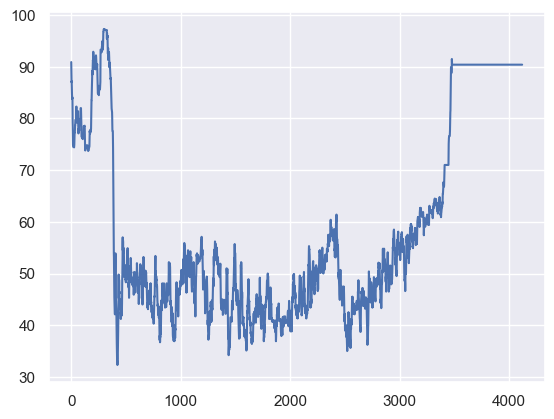

In [11]:
# Replacing the zero values in BIS
from scipy.interpolate import interp1d

def replace_zeroes_with_interpolation(series):
    # Find indices and values of non-zero elements
    non_zero_indices = [i for i, val in enumerate(series) if val != 0]
    non_zero_values = [series[i] for i in non_zero_indices]

    # Create an interpolation function using scipy's interp1d
    interpolation_function = interp1d(non_zero_indices, non_zero_values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Replace zeroes with interpolated values
    new_series = [interpolation_function(i) if val == 0 else val for i, val in enumerate(series)]

    return new_series

# Test the function
series = selected_bis
new_bis = replace_zeroes_with_interpolation(series)
plt.plot(new_bis)
print("Number of BIS before windowing:", len(new_bis))

Number of BIS before windowing: 527360


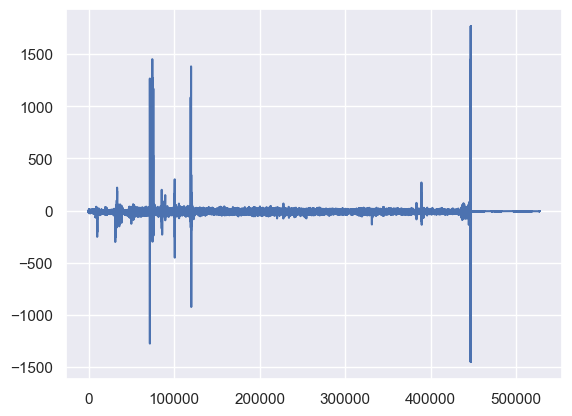

In [13]:
new_eeg = replace_zeroes_with_interpolation(selected_EEG)
plt.plot(new_eeg)
print("Number of BIS before windowing:", len(new_eeg))

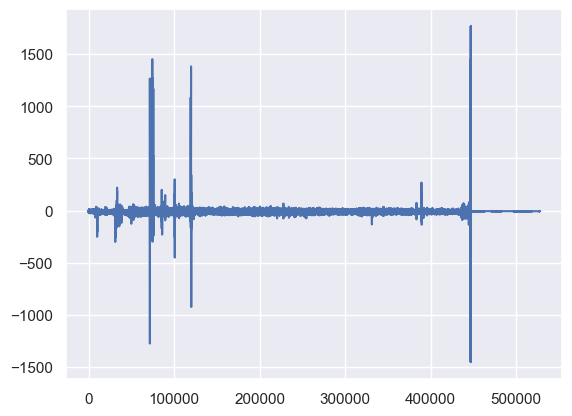

In [14]:
plt.plot(selected_EEG)

### Bandpass filtering

In [8]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)

### Windowing

Number of BIS: 4065


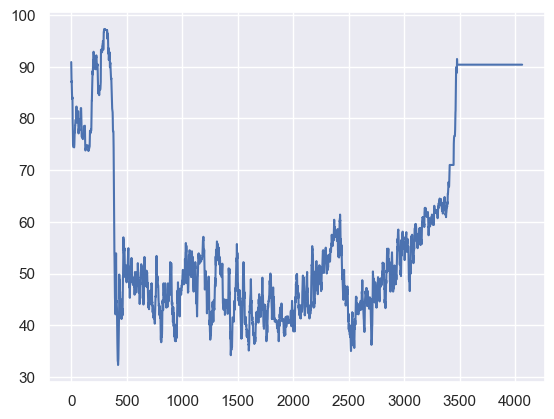

In [9]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = new_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


### Variational Mode Decomposition (VMD)

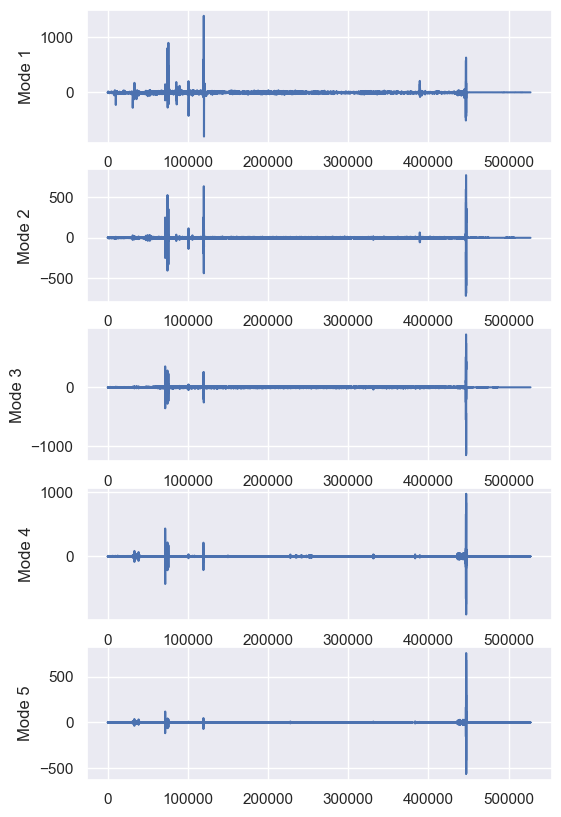

In [12]:
signal = selected_EEG

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Save the modes in csv

In [14]:
np.savetxt("modes0.csv", modes[0], delimiter=",", header="modes0")
np.savetxt("modes1.csv", modes[1], delimiter=",", header="modes1")
np.savetxt("modes2.csv", modes[2], delimiter=",", header="modes2")
np.savetxt("modes3.csv", modes[3], delimiter=",", header="modes3")
np.savetxt("modes4.csv", modes[4], delimiter=",", header="modes4")

### Windowing and Features extraction

In [16]:
#### For entropies

def moving_sliding_window(data, method, window_size_sec=56, overlap_sec=55, sampling_rate=128):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            embedding_dimension = 2
            tolerance = 0.2
            sample_entropy = sampen(window, emb_dim=embedding_dimension, tolerance=tolerance)
            result.append(sample_entropy)
    
            
        if method == "spectral entropy":
            # Calculate sample entropy within the window
            sf=128
            spectral_entropy = ant.spectral_entropy(window, sf)
            result.append(spectral_entropy)
            
            
        if method == "lzc":
            # Calculate sample entropy within the window
            lzc_entropy = ant.lziv_complexity(window)
            result.append(lzc_entropy)
            
        if method == "svd":
            # Calculate sample entropy within the window
            svd_entropy = ant.svd_entropy(window)
            result.append(svd_entropy)
            
        if method == "dispm":
            # Calculate dispersion_entropy_multiscale_refined within the window
            disp_m, prob = sp.dispersion_entropy_multiscale_refined(window,classes=2, emb_dim=3, delay=1,return_all=False)
            result.append(disp_m)

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=2, scale=4, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "fuzzy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window, m=3, r=0.5, Fx='gudermannian')
            #Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=5, delay=1,return_all=False)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
            
            # Higuchi Fractal Dimension
        if method == "hfd":
            hfd = ant.higuchi_fd(window)
            result.append(hfd)
          
            # # Katz Fractal Dimension
        if method == "kfd":
            kfd = ant.katz_fd(window)
            result.append(kfd)
            
    
        
    return result


In [17]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 4065


Number of features: 4065


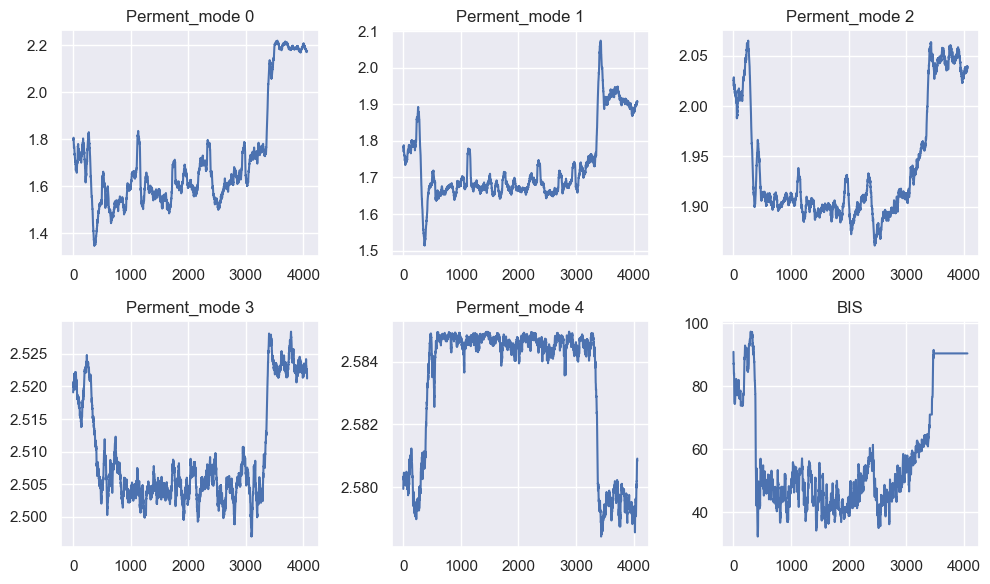

In [18]:
print(f"Number of features:", len(resultsp_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [19]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspet_0 = moving_sliding_window(data0, method='pet')
resultspet_1 = moving_sliding_window(data1, method='pet')
resultspet_2 = moving_sliding_window(data2, method='pet')
resultspet_3 = moving_sliding_window(data3, method='pet')
resultspet_4 = moving_sliding_window(data4, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 4065


Number of features: 4065


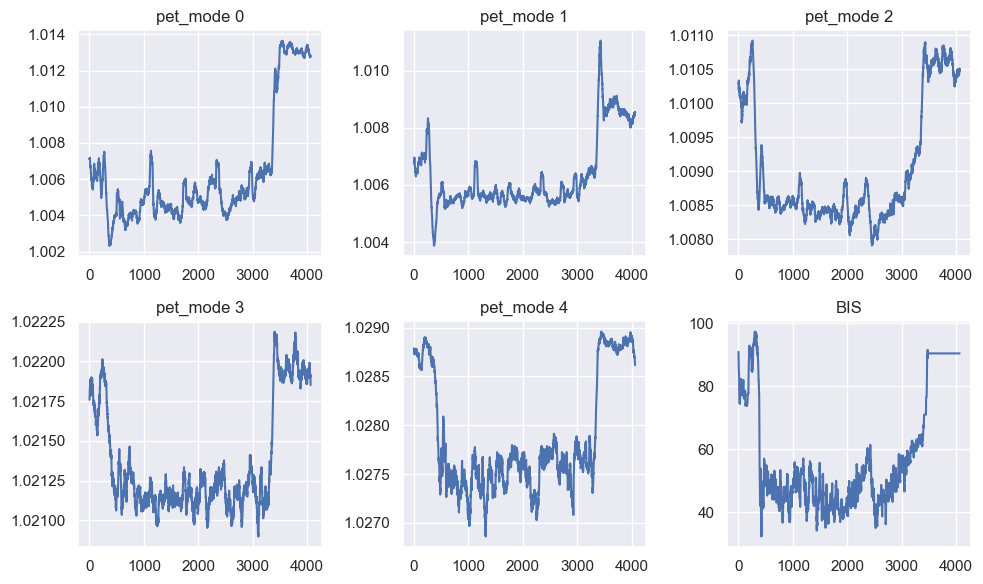

In [20]:
print(f"Number of features:", len(resultspet_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspet_0)
axes[0, 0].set_title('pet_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspet_1)
axes[0, 1].set_title('pet_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspet_2)
axes[0, 2].set_title('pet_mode 2')

axes[1, 0].plot(resultspet_3)
axes[1, 0].set_title('pet_mode 3')

axes[1, 1].plot(resultspet_4)
axes[1, 1].set_title('pet_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [21]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshc_0 = moving_sliding_window(data0, method='hc')
resultshc_1 = moving_sliding_window(data1, method='hc')
resultshc_2 = moving_sliding_window(data2, method='hc')
resultshc_3 = moving_sliding_window(data3, method='hc')
resultshc_4 = moving_sliding_window(data4, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 4065


Number of features: 4065


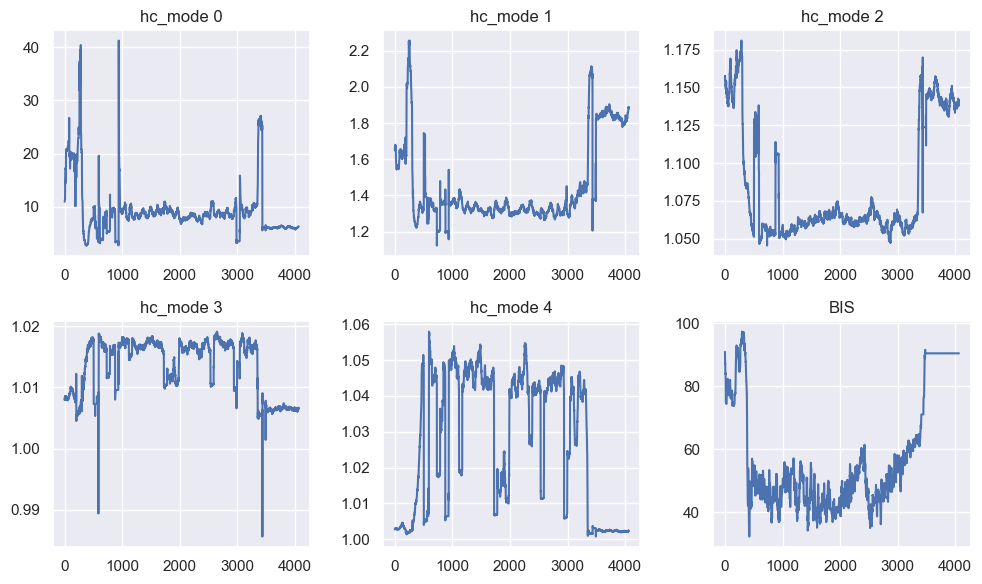

In [22]:
print(f"Number of features:", len(resultshc_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshc_0)
axes[0, 0].set_title('hc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshc_1)
axes[0, 1].set_title('hc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshc_2)
axes[0, 2].set_title('hc_mode 2')

axes[1, 0].plot(resultshc_3)
axes[1, 0].set_title('hc_mode 3')

axes[1, 1].plot(resultshc_4)
axes[1, 1].set_title('hc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [23]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshm_0 = moving_sliding_window(data0,  method='hm')
resultshm_1 = moving_sliding_window(data1, method='hm')
resultshm_2 = moving_sliding_window(data2, method='hm')
resultshm_3 = moving_sliding_window(data3, method='hm')
resultshm_4 = moving_sliding_window(data4, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 4065


Number of features: 4065


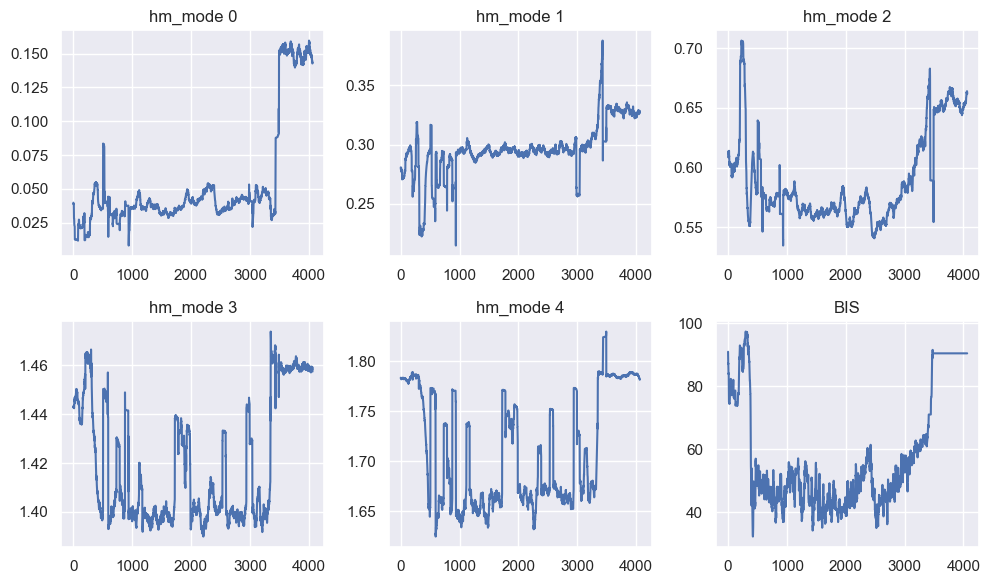

In [24]:
print(f"Number of features:", len(resultshm_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshm_0)
axes[0, 0].set_title('hm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshm_1)
axes[0, 1].set_title('hm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshm_2)
axes[0, 2].set_title('hm_mode 2')

axes[1, 0].plot(resultshm_3)
axes[1, 0].set_title('hm_mode 3')

axes[1, 1].plot(resultshm_4)
axes[1, 1].set_title('hm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [25]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspec_0 = moving_sliding_window(data0, method='spectral entropy')
resultspec_1 = moving_sliding_window(data1, method='spectral entropy')
resultspec_2 = moving_sliding_window(data2, method='spectral entropy')
resultspec_3 = moving_sliding_window(data3, method='spectral entropy')
resultspec_4 = moving_sliding_window(data4, method='spectral entropy')
print(f"Number of features:", len(resultspec_1))

Number of features: 4065


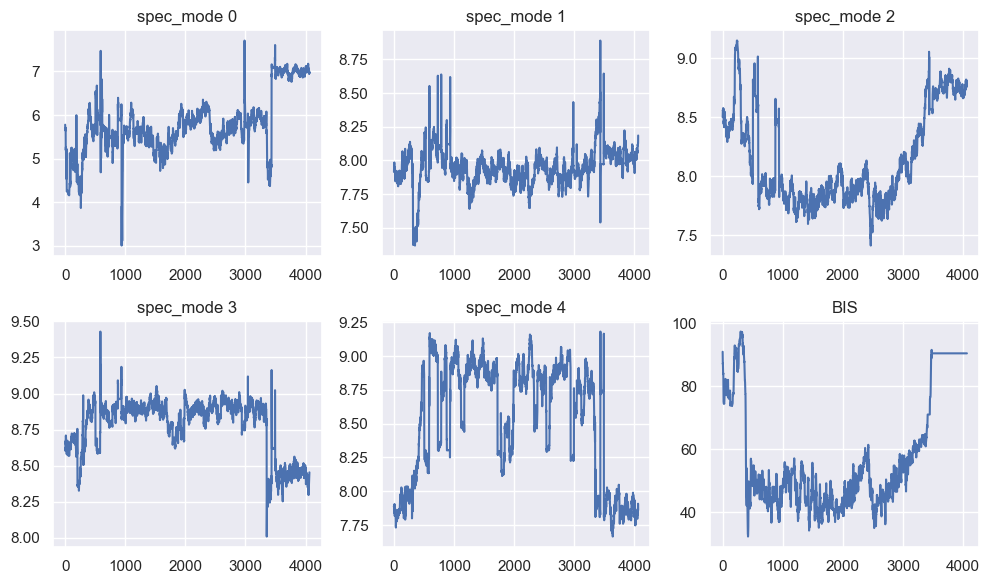

In [26]:
# spectral entropy


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspec_0)
axes[0, 0].set_title('spec_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspec_1)
axes[0, 1].set_title('spec_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspec_2)
axes[0, 2].set_title('spec_mode 2')

axes[1, 0].plot(resultspec_3)
axes[1, 0].set_title('spec_mode 3')

axes[1, 1].plot(resultspec_4)
axes[1, 1].set_title('spec_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [27]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsvd_0 = moving_sliding_window(data0, method='svd')
resultsvd_1 = moving_sliding_window(data1, method='svd')
resultsvd_2 = moving_sliding_window(data2, method='svd')
resultsvd_3 = moving_sliding_window(data3, method='svd')
resultsvd_4 = moving_sliding_window(data4, method='svd')
print(f"Number of features:", len(resultsvd_1))

Number of features: 4065


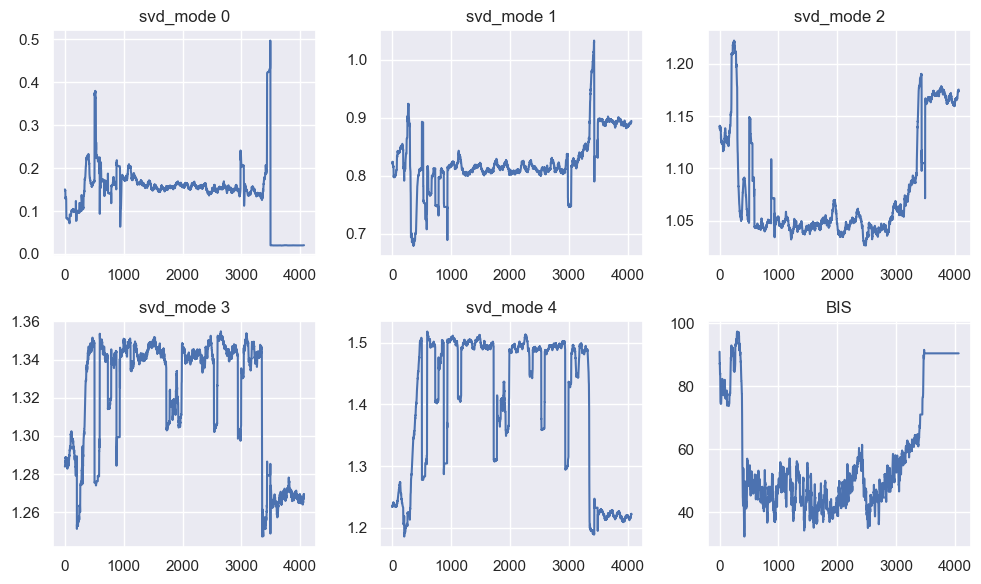

In [28]:
# svd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsvd_0)
axes[0, 0].set_title('svd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsvd_1)
axes[0, 1].set_title('svd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsvd_2)
axes[0, 2].set_title('svd_mode 2')

axes[1, 0].plot(resultsvd_3)
axes[1, 0].set_title('svd_mode 3')

axes[1, 1].plot(resultsvd_4)
axes[1, 1].set_title('svd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [29]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultslzc_0 = moving_sliding_window(data0, method='lzc')
resultslzc_1 = moving_sliding_window(data1, method='lzc')
resultslzc_2 = moving_sliding_window(data2, method='lzc')
resultslzc_3 = moving_sliding_window(data3, method='lzc')
resultslzc_4 = moving_sliding_window(data4, method='lzc')
print(f"Number of features:", len(resultslzc_1))

Number of features: 4065


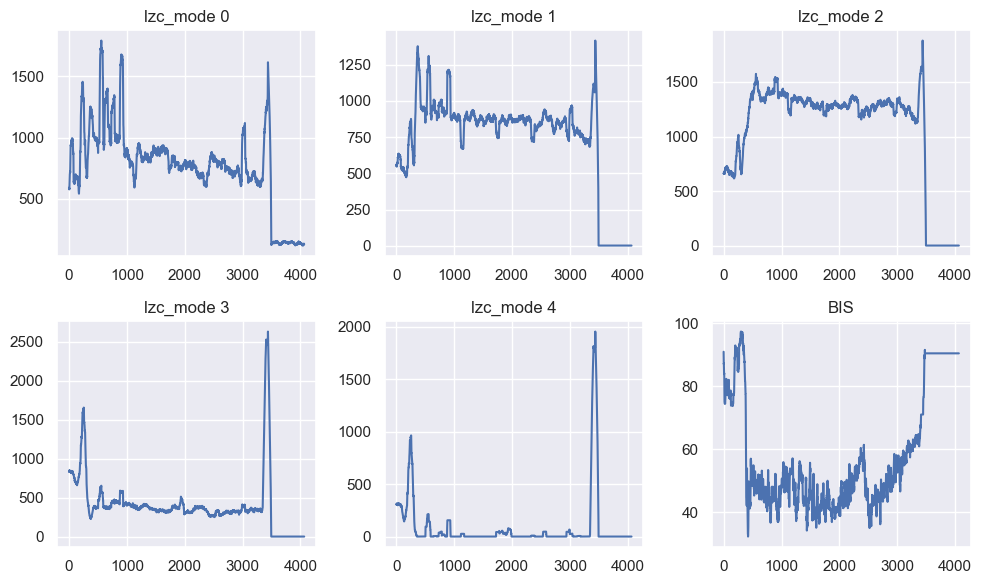

In [30]:
# Lzc


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultslzc_0)
axes[0, 0].set_title('lzc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultslzc_1)
axes[0, 1].set_title('lzc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultslzc_2)
axes[0, 2].set_title('lzc_mode 2')

axes[1, 0].plot(resultslzc_3)
axes[1, 0].set_title('lzc_mode 3')

axes[1, 1].plot(resultslzc_4)
axes[1, 1].set_title('lzc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()

ant.higuchi_fd

# Display the figure
plt.show()

In [31]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultskfd_0 = moving_sliding_window(data0, method='kfd')
resultskfd_1 = moving_sliding_window(data1, method='kfd')
resultskfd_2 = moving_sliding_window(data2, method='kfd')
resultskfd_3 = moving_sliding_window(data3, method='kfd')
resultskfd_4 = moving_sliding_window(data4, method='kfd')
print(f"Number of features:", len(resultskfd_1))

Number of features: 4065


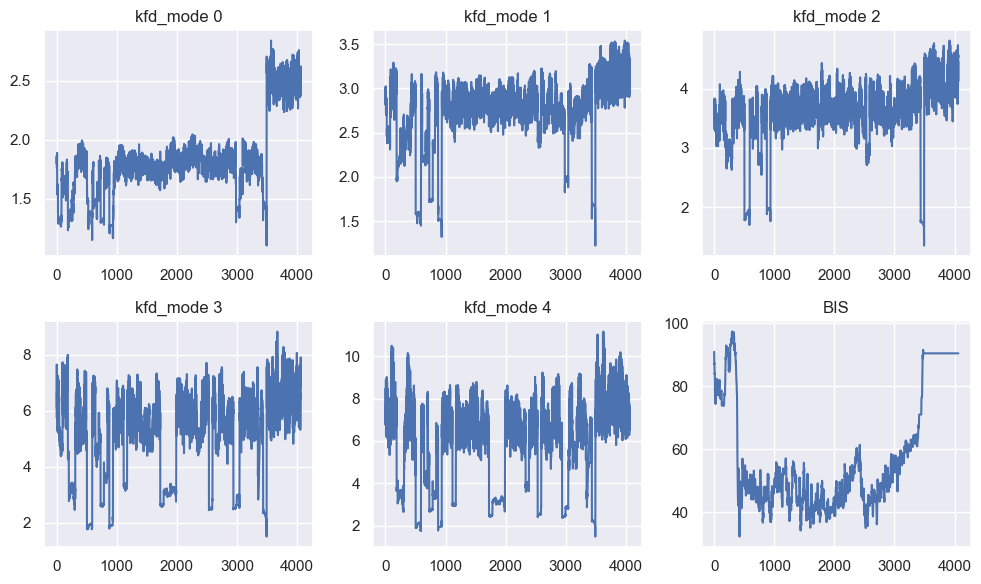

In [32]:
# kfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultskfd_0)
axes[0, 0].set_title('kfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultskfd_1)
axes[0, 1].set_title('kfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultskfd_2)
axes[0, 2].set_title('kfd_mode 2')

axes[1, 0].plot(resultskfd_3)
axes[1, 0].set_title('kfd_mode 3')

axes[1, 1].plot(resultskfd_4)
axes[1, 1].set_title('kfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [33]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultshfd_0 = moving_sliding_window(data0, method='hfd')
resultshfd_1 = moving_sliding_window(data1, method='hfd')
resultshfd_2 = moving_sliding_window(data2, method='hfd')
resultshfd_3 = moving_sliding_window(data3, method='hfd')
resultshfd_4 = moving_sliding_window(data4, method='hfd')
print(f"Number of features:", len(resultshfd_0))

Number of features: 4065


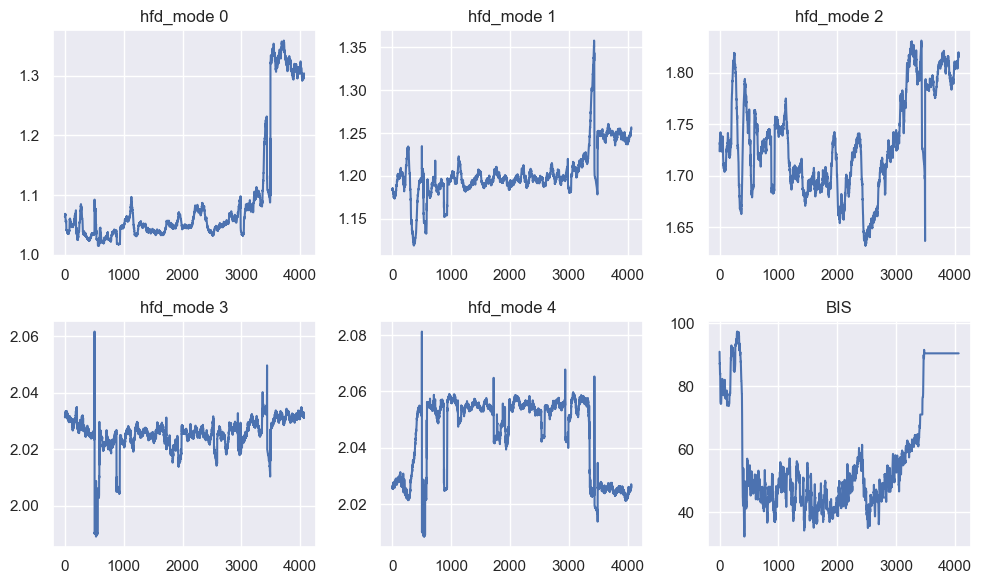

In [34]:
# hfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshfd_0)
axes[0, 0].set_title('hfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshfd_1)
axes[0, 1].set_title('hfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshfd_2)
axes[0, 2].set_title('hfd_mode 2')

axes[1, 0].plot(resultshfd_3)
axes[1, 0].set_title('hfd_mode 3')

axes[1, 1].plot(resultshfd_4)
axes[1, 1].set_title('hfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [35]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsa_0 = moving_sliding_window(data0, method='sample entropy')
resultsa_1 = moving_sliding_window(data1, method='sample entropy')
resultsa_2 = moving_sliding_window(data2, method='sample entropy')
resultsa_3 = moving_sliding_window(data3, method='sample entropy')
resultsa_4 = moving_sliding_window(data4, method='sample entropy')
print(f"Number of features:", len(resultsa_0))

KeyboardInterrupt: 

In [36]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsdt_0 = moving_sliding_window(data0, method='detf')
resultsdt_1 = moving_sliding_window(data1, method='detf')
resultsdt_2 = moving_sliding_window(data2, method='detf')
resultsdt_3 = moving_sliding_window(data3, method='detf')
resultsdt_4 = moving_sliding_window(data4, method='detf')
print(f"Number of features:", len(resultsdt_0))

Number of features: 4065


Number of features: 4065


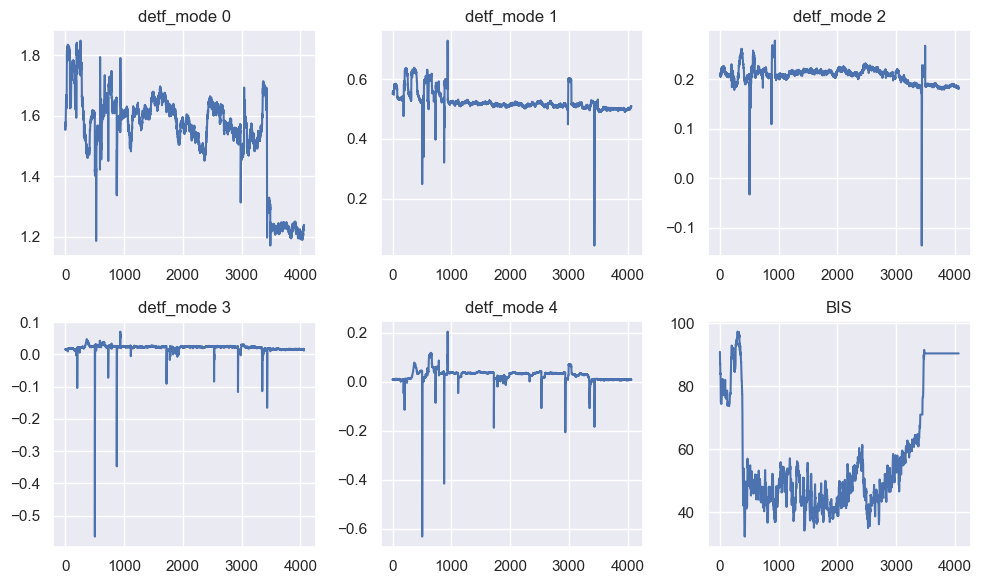

In [37]:
print(f"Number of features:", len(resultsdt_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdt_0)
axes[0, 0].set_title('detf_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdt_1)
axes[0, 1].set_title('detf_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdt_2)
axes[0, 2].set_title('detf_mode 2')

axes[1, 0].plot(resultsdt_3)
axes[1, 0].set_title('detf_mode 3')

axes[1, 1].plot(resultsdt_4)
axes[1, 1].set_title('detf_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [38]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]



# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 4065


Number of features: 4065


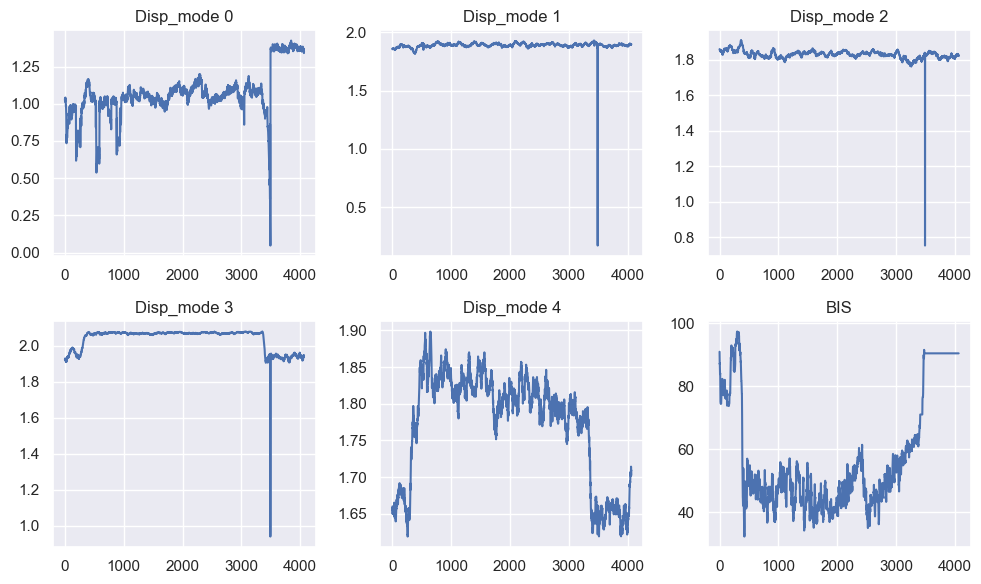

In [39]:
print(f"Number of features:", len(resultsd_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [40]:
### data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

resultsdispm_0 = moving_sliding_window(data0, method='dispm')
resultsdispm_1 = moving_sliding_window(data1, method='dispm')
resultsdispm_2 = moving_sliding_window(data2, method='dispm')
resultsdispm_3 = moving_sliding_window(data3, method='dispm')
resultsdispm_4 = moving_sliding_window(data4, method='dispm')
print(f"Number of features:", len(resultsdispm_1))

Number of features: 4065


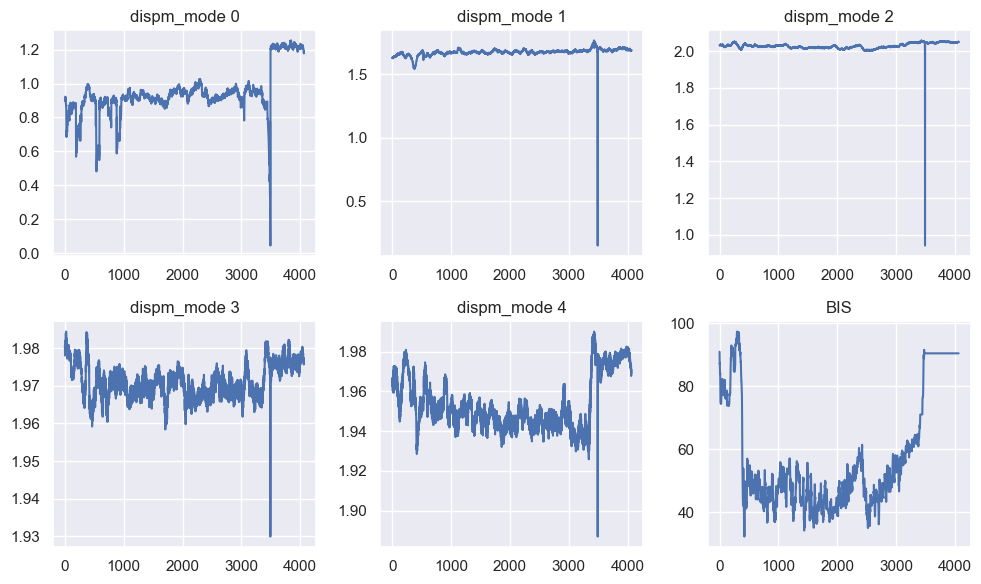

In [41]:
# dispm


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdispm_0)
axes[0, 0].set_title('dispm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdispm_1)
axes[0, 1].set_title('dispm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdispm_2)
axes[0, 2].set_title('dispm_mode 2')

axes[1, 0].plot(resultsdispm_3)
axes[1, 0].set_title('dispm_mode 3')

axes[1, 1].plot(resultsdispm_4)
axes[1, 1].set_title('dispm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

### Create Dataframe for each feature and find the correlation


In [289]:
# lzc

df_lzc = pd.DataFrame({'lzc_mode0': resultslzc_0, 'lzc_mode1': resultslzc_1, 'lzc_mode2': resultslzc_2, 'lzc_mode3': resultslzc_3, 'lzc_mode4': resultslzc_4})

df_lzc['BIS']=bis_windows


In [290]:
# svd

df_svd = pd.DataFrame({'svd_mode0': resultsvd_0, 'svd_mode1': resultsvd_1, 'svd_mode2': resultsvd_2, 'svd_mode3': resultsvd_3, 'svd_mode4': resultsvd_4})

df_svd['BIS']=bis_windows

In [291]:
# spectral entropy

df_spec = pd.DataFrame({'spec_mode0': resultspec_0, 'spec_mode1': resultspec_1, 'spec_mode2': resultspec_2, 'spec_mode3': resultspec_3, 'spec_mode4': resultspec_4})

df_spec['BIS']=bis_windows


In [292]:
# dispm

df_dispm = pd.DataFrame({'dispm_mode0': resultsdispm_0, 'dispm_mode1': resultsdispm_1, 'dispm_mode2': resultsdispm_2, 'dispm_mode3': resultsdispm_3, 'dispm_mode4': resultsdispm_4})

df_dispm['BIS']=bis_windows


In [293]:
# kfd

df_kfd = pd.DataFrame({'kfd_mode0': resultskfd_0, 'kfd_mode1': resultskfd_1, 'kfd_mode2': resultskfd_2, 'kfd_mode3': resultskfd_3, 'kfd_mode4': resultskfd_4})

df_kfd['BIS']=bis_windows


In [294]:
# hfd

df_hfd = pd.DataFrame({'hfd_mode0': resultshfd_0, 'hfd_mode1': resultshfd_1, 'hfd_mode2': resultshfd_2, 'hfd_mode3': resultshfd_3, 'hfd_mode4': resultshfd_4})

df_hfd['BIS']=bis_windows

In [48]:
# detf

df_detf = pd.DataFrame({'detf_mode0': resultsdt_0, 'detf_mode1': resultsdt_1, 'detf_mode2': resultsdt_2, 'detf_mode3': resultsdt_3, 'detf_mode4': resultsdt_4})

df_detf['BIS']=bis_windows
#df_detf


In [ ]:
# sample entropy

df_samp = pd.DataFrame({'samp_mode0': resultsa_0, 'samp_mode1': resultsa_1, 'samp_mode2': resultsa_2, 'samp_mode3': resultsa_3, 'samp_mode4': resultsa_4})

df_samp['BIS']=bis_windows
df_samp


In [49]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
#df_pet



In [50]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


In [51]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
#df_hc


In [52]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

In [53]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

### Save the extracted data in csv

In [54]:
df_detf.to_csv('detf_78.csv' , index=False)
df_hm.to_csv('hm_78.csv', index=False)
df_hc.to_csv('hc_78.csv', index=False)
df_perm.to_csv('perm_78.csv', index=False)
df_pet.to_csv('pet_78.csv', index=False)
df_disp.to_csv('disp_78.csv', index=False)

In [107]:
df_lzc.to_csv('lzc_78.csv' , index=False)
df_kfd.to_csv('kfd_78.csv', index=False)
df_hfd.to_csv('hfd_78.csv', index=False)
df_spec.to_csv('spec_78.csv', index=False)
df_svd.to_csv('svd_78.csv', index=False)
df_dispm.to_csv('dispm_78.csv', index=False)

### Regression

In [58]:
metrics = {}
def plot_regression(data, column):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X_train, y_train)
    
    # Predictions
    y_predicted = reg.predict(X_test)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    
    # Plot the graph#
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="data", c="blue")
    plt.plot(X_test, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

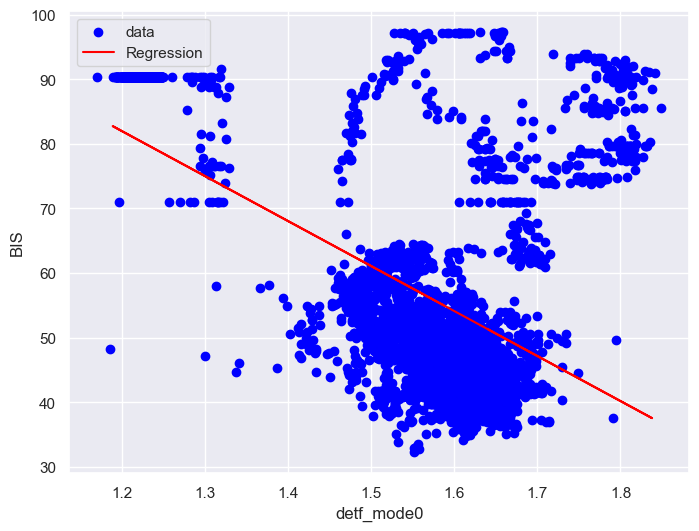

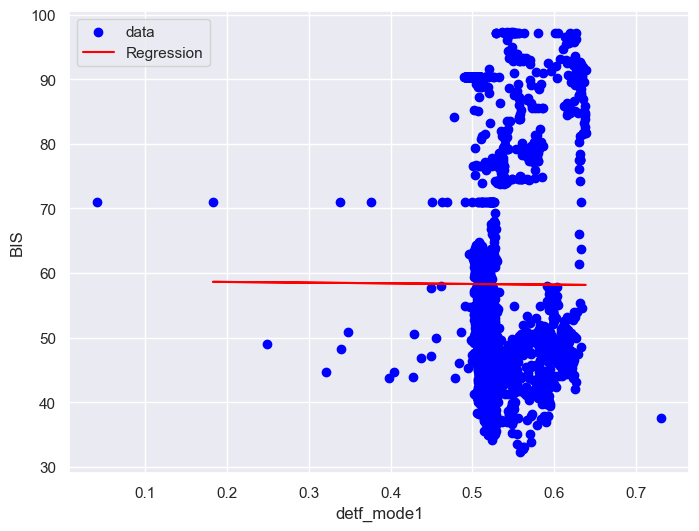

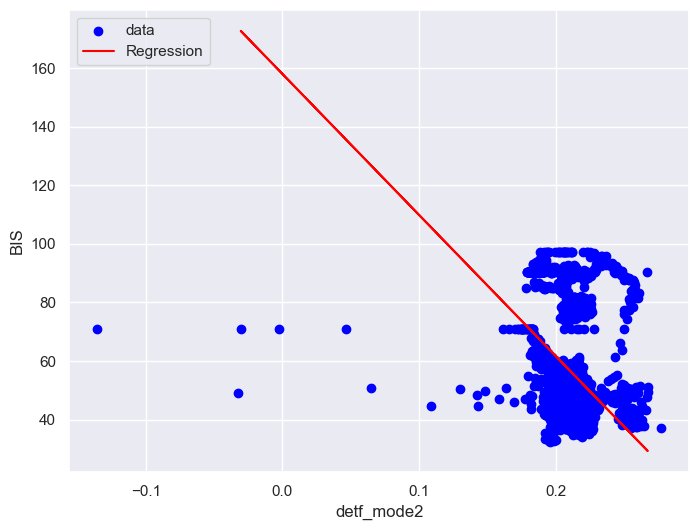

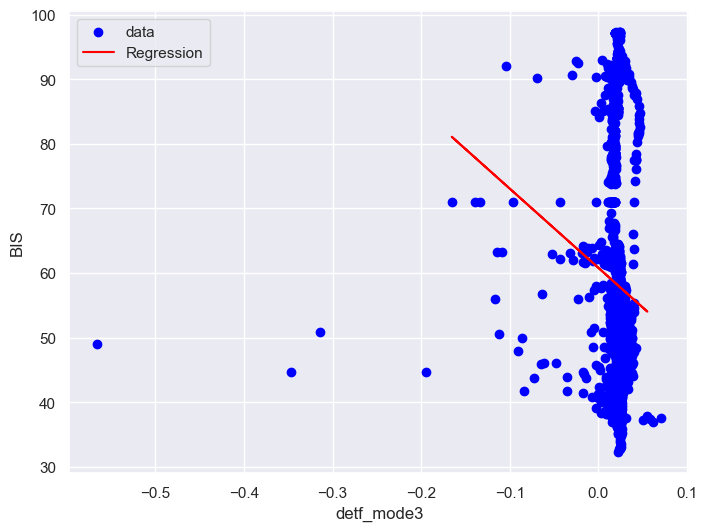

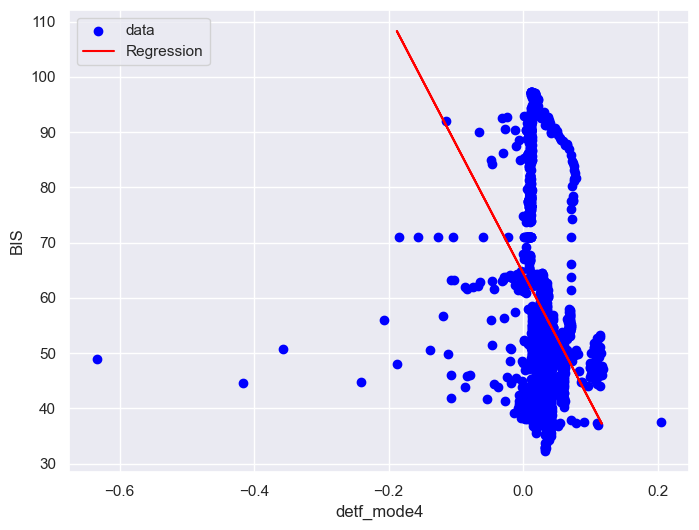

In [59]:
for column in df_detf.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_detf, column)

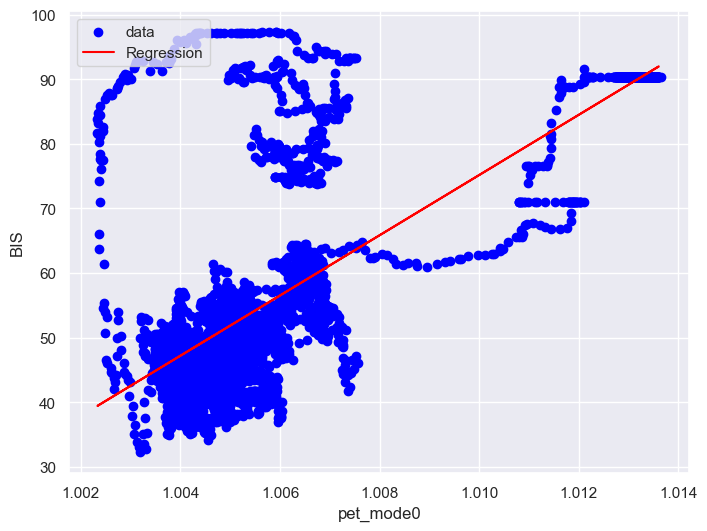

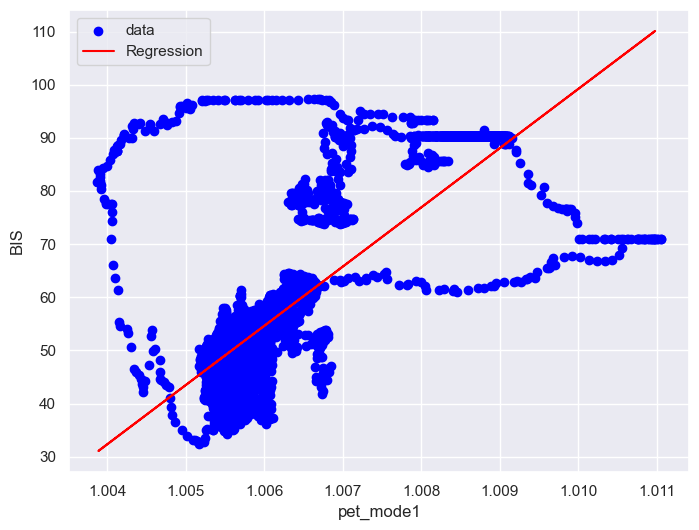

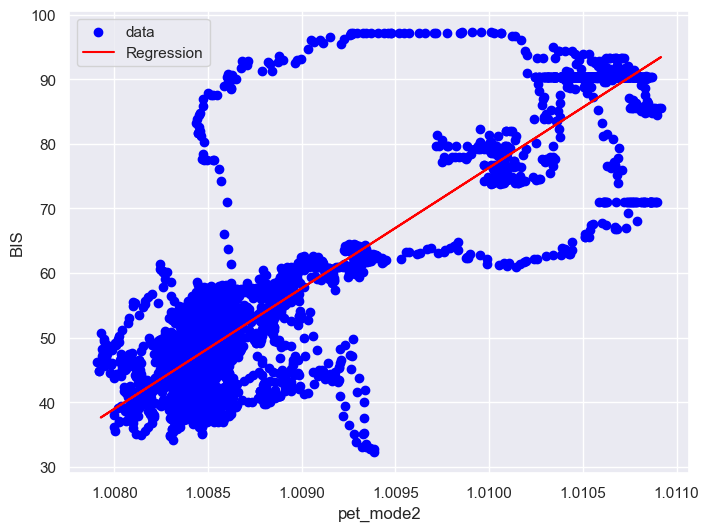

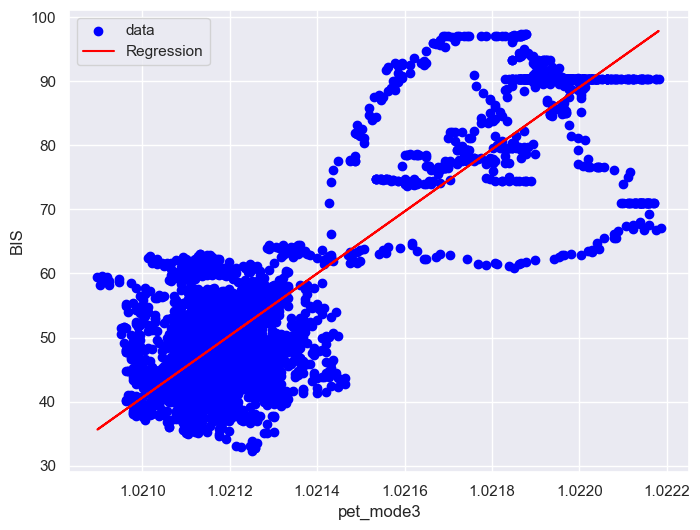

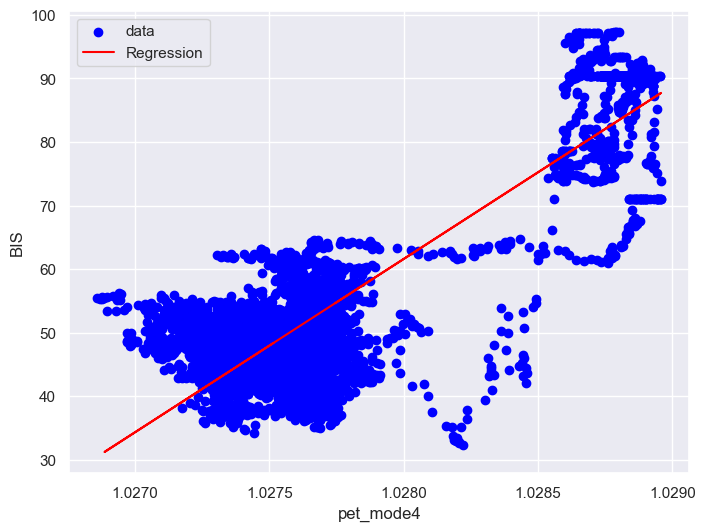

In [60]:
for column in df_pet.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_pet, column)

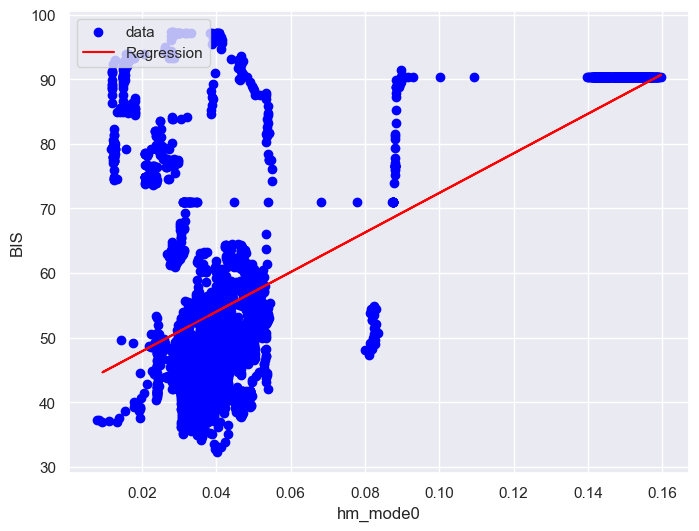

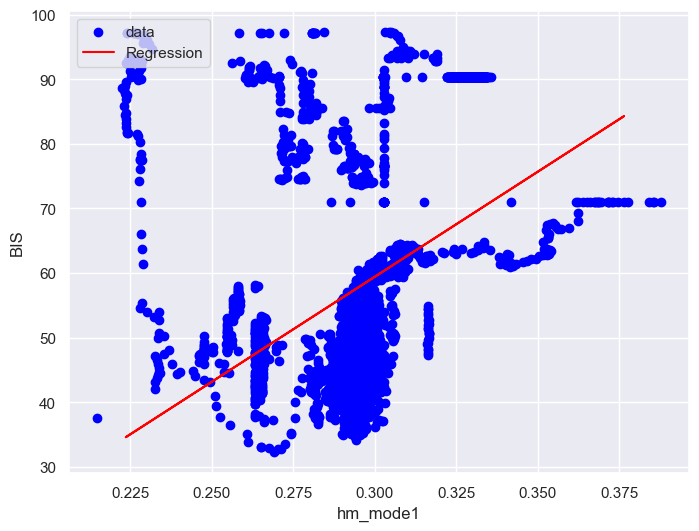

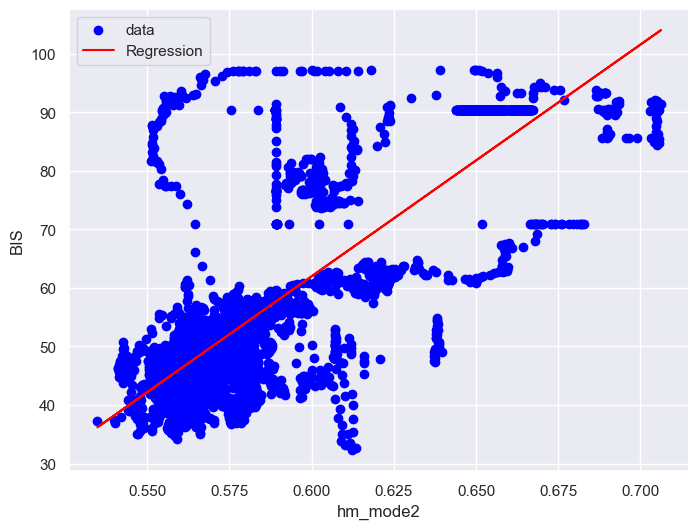

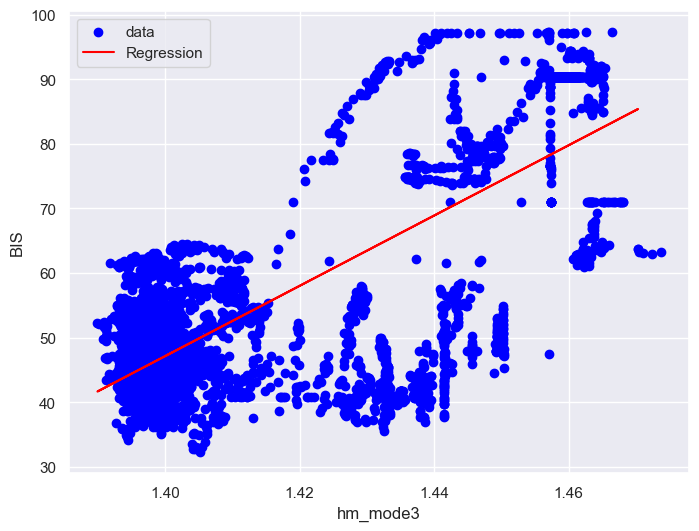

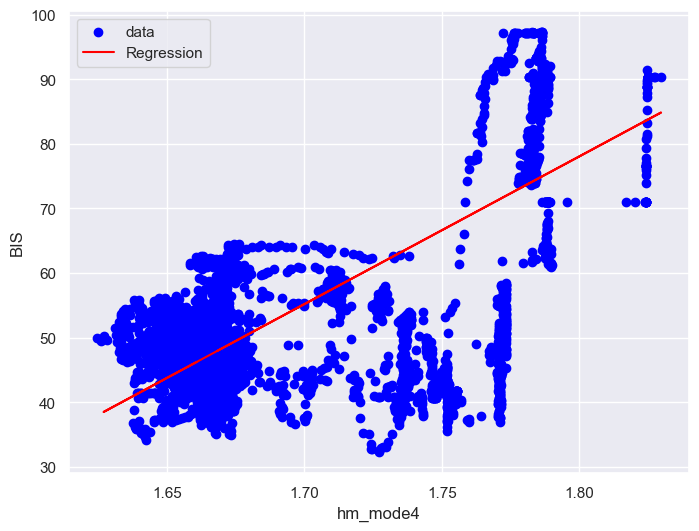

In [61]:
for column in df_hm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hm, column)

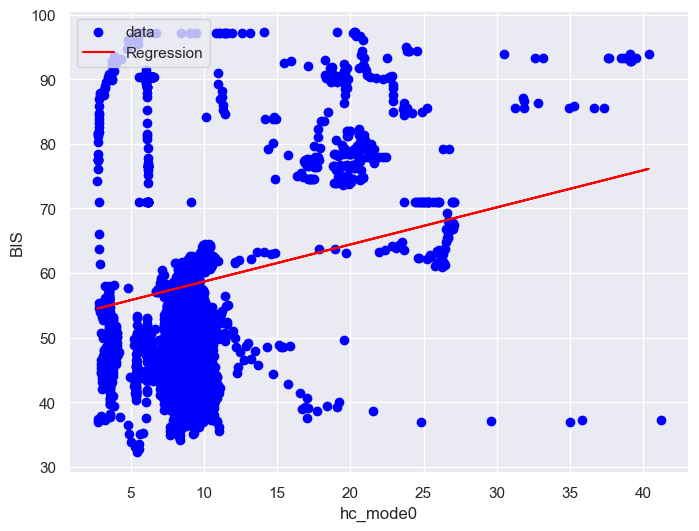

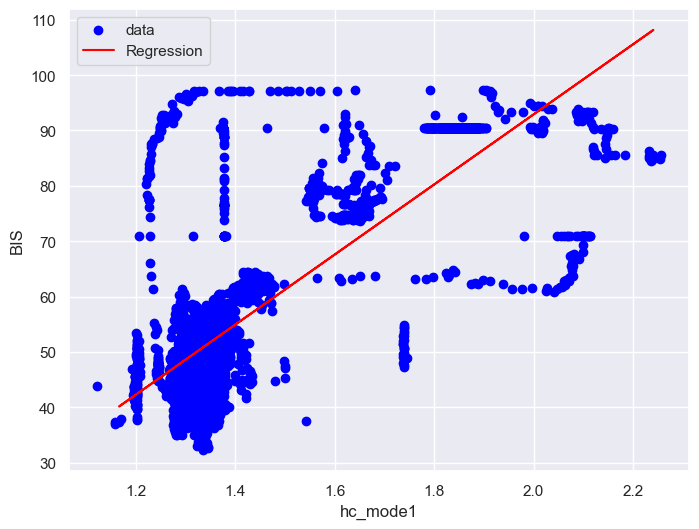

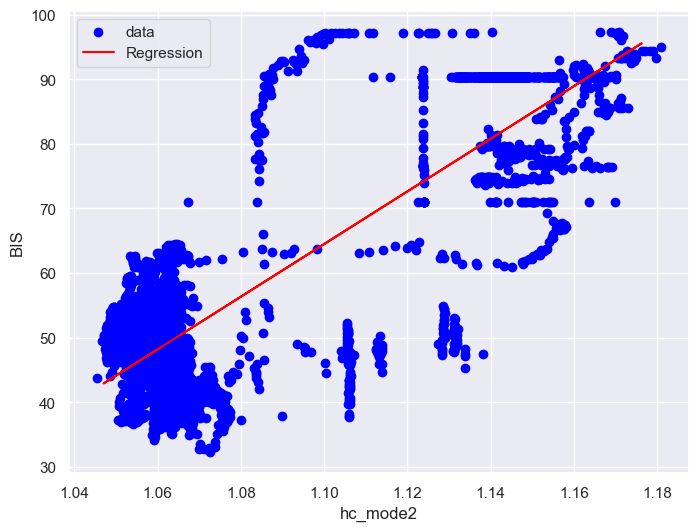

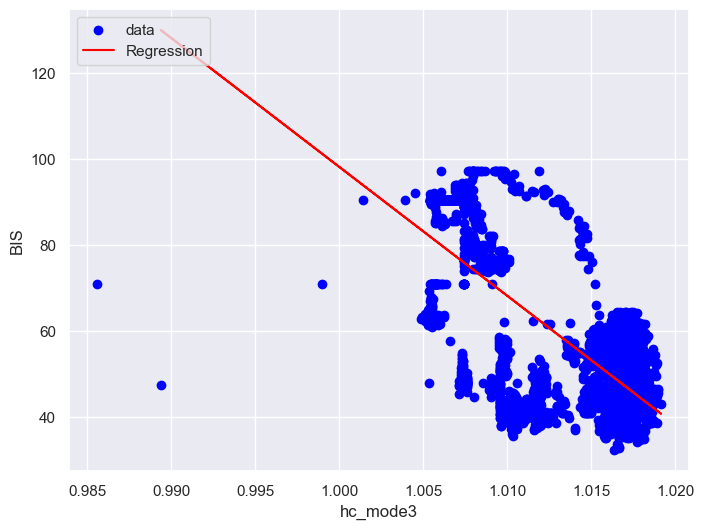

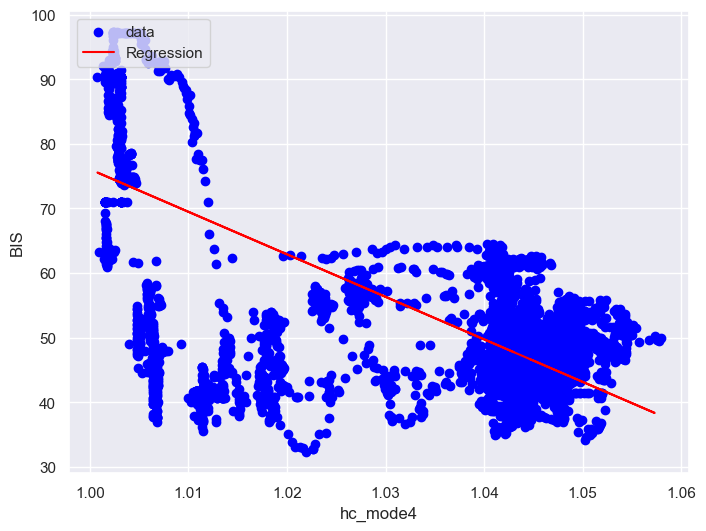

In [62]:
for column in df_hc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hc, column)

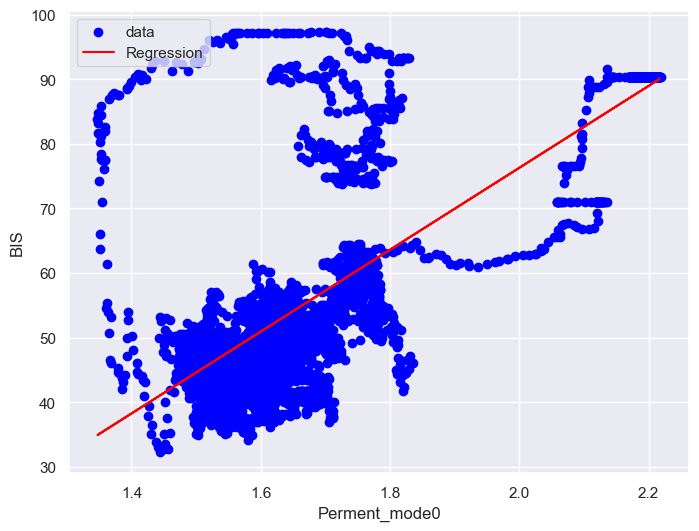

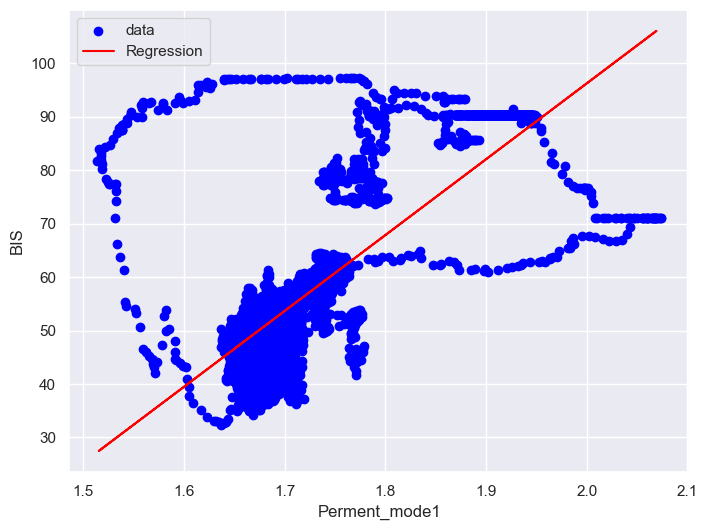

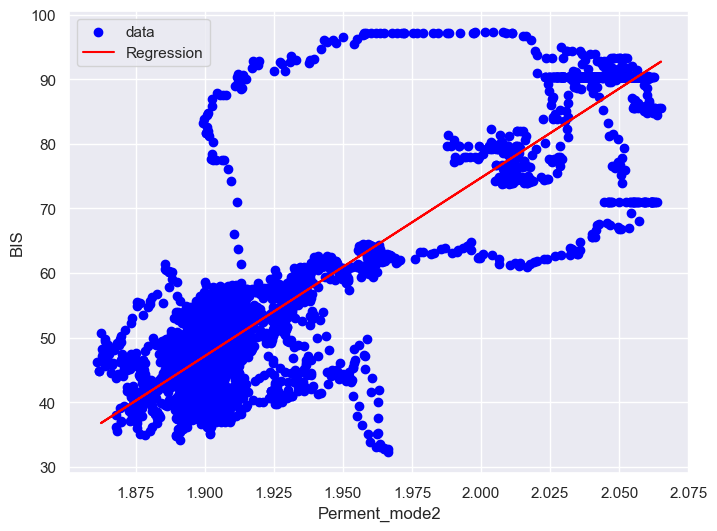

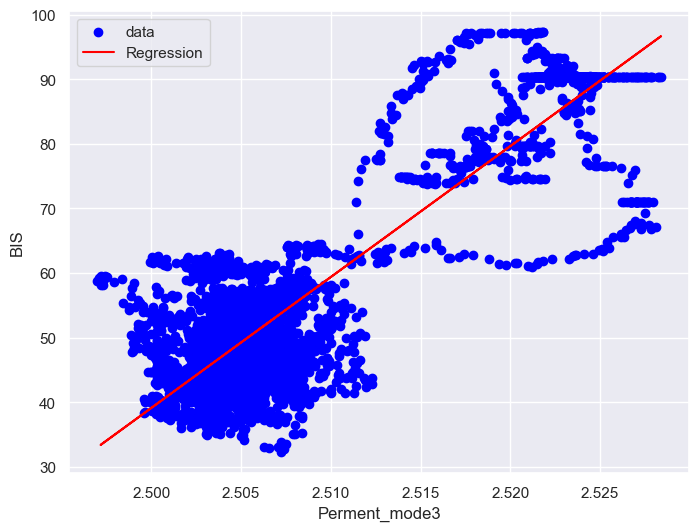

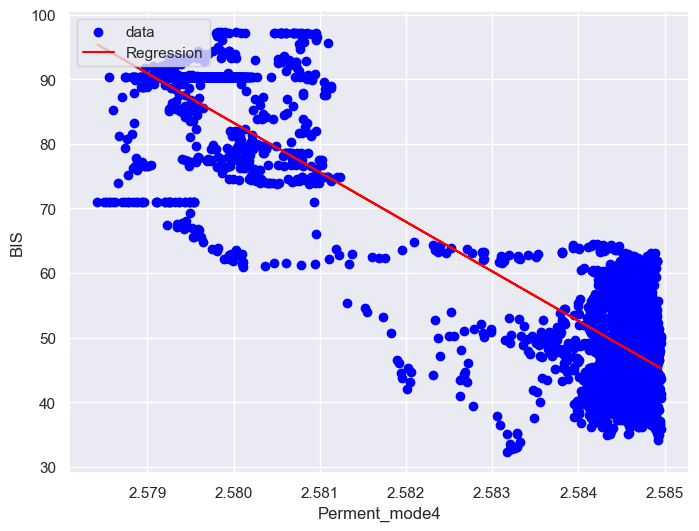

In [63]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

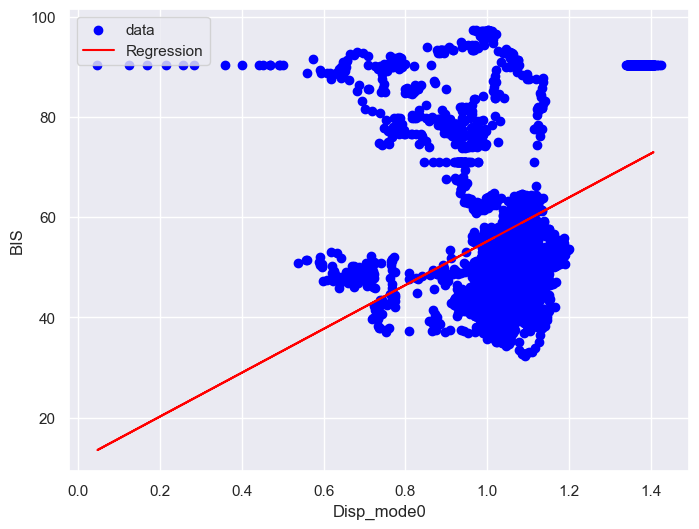

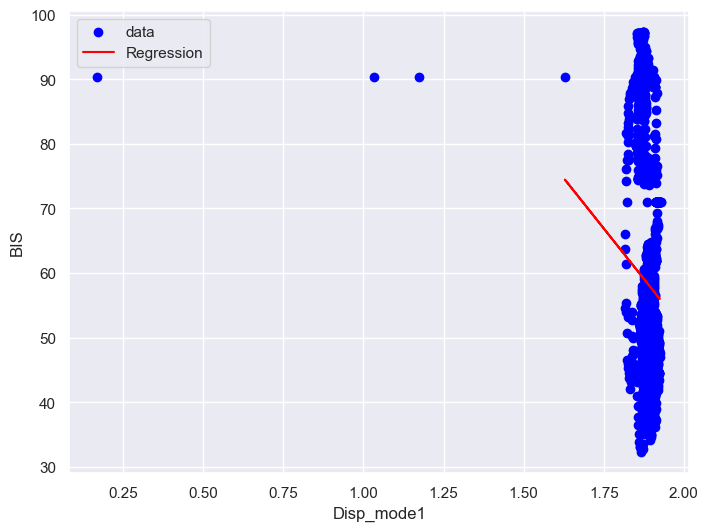

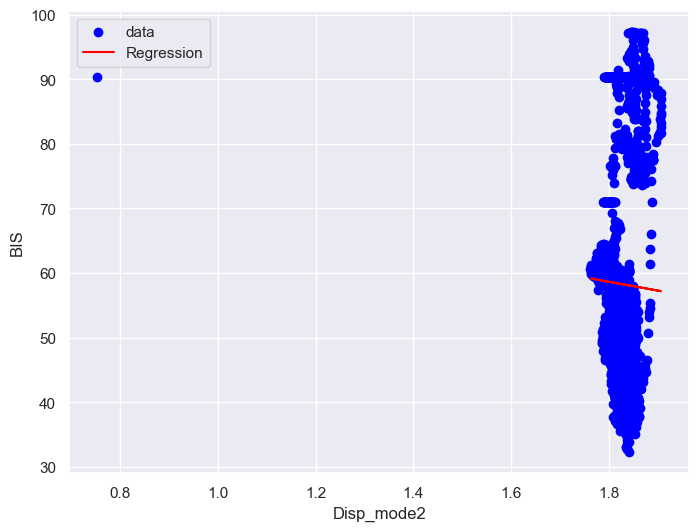

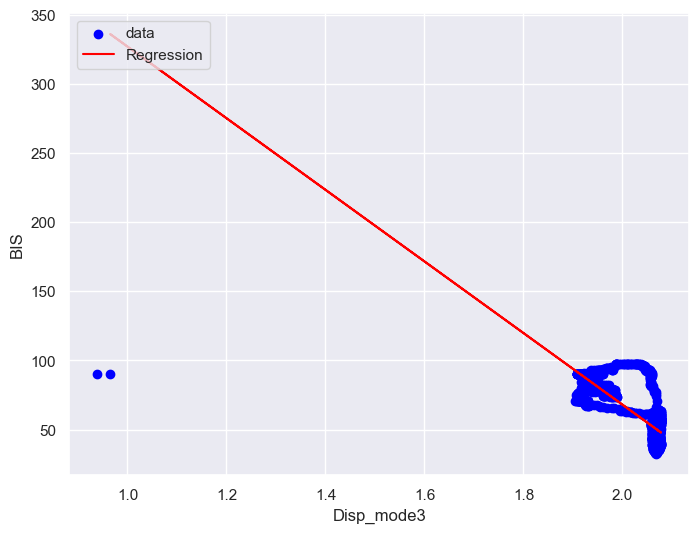

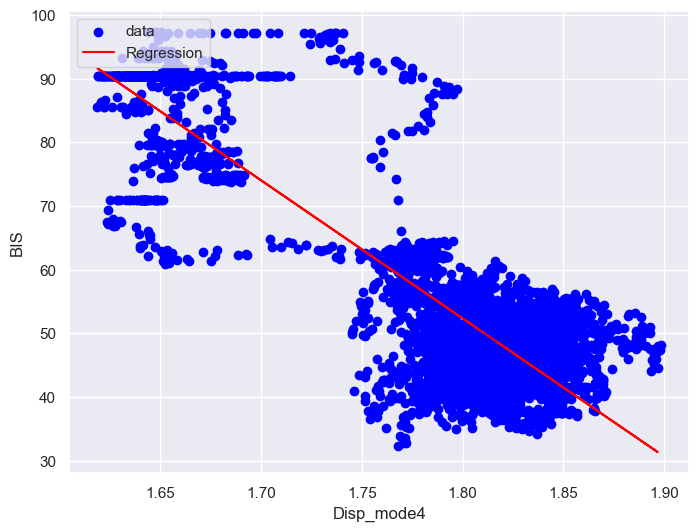

In [64]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

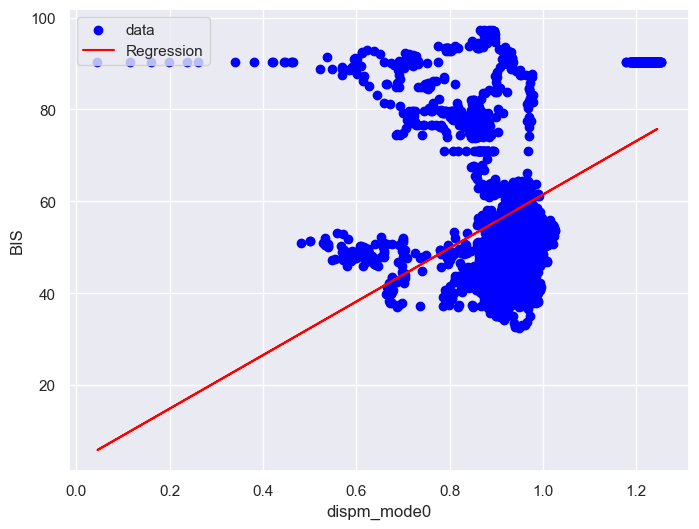

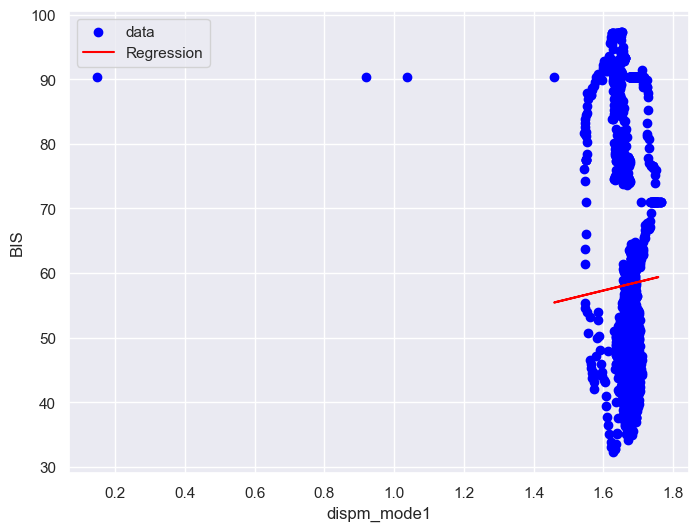

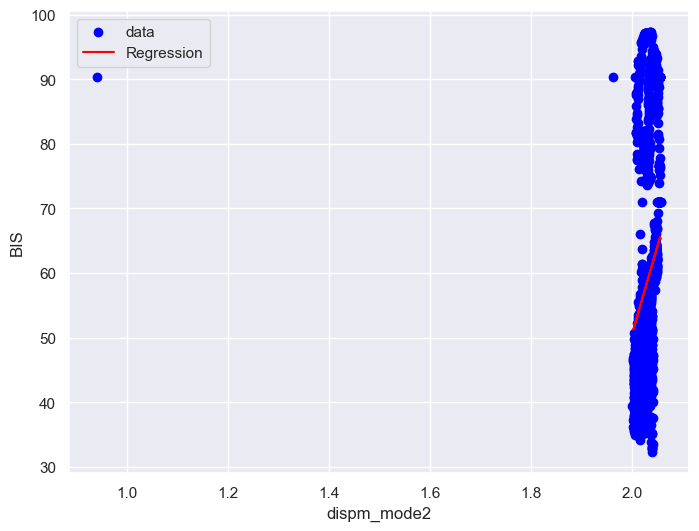

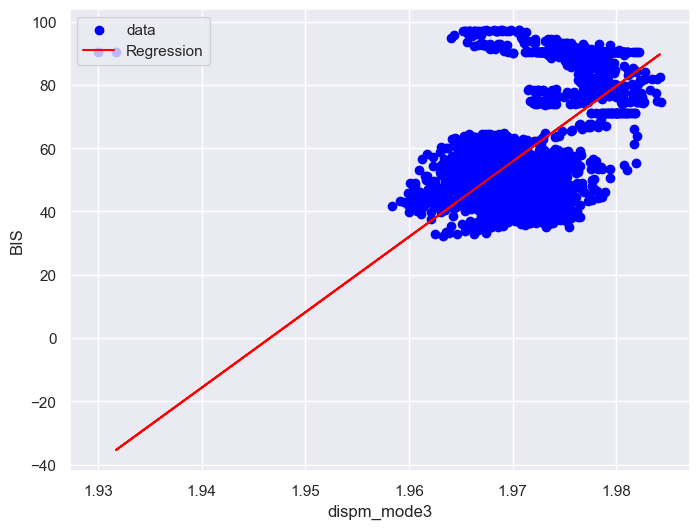

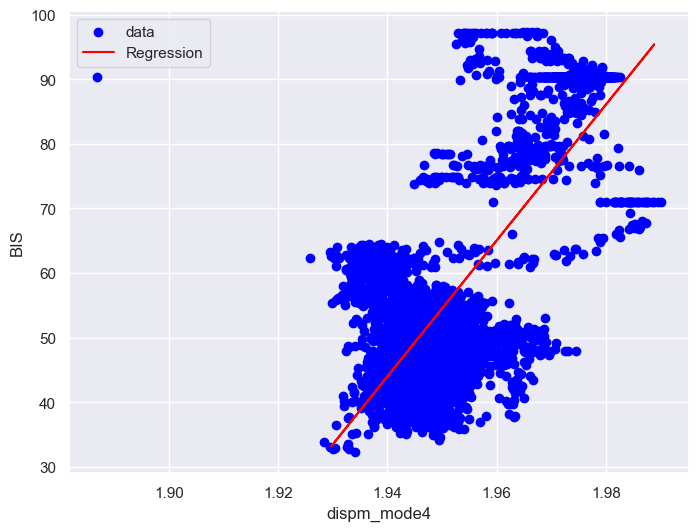

In [108]:
for column in df_dispm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_dispm, column)

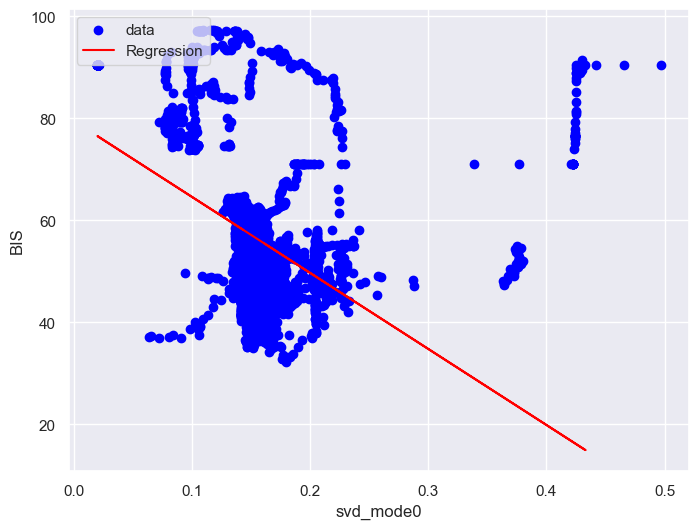

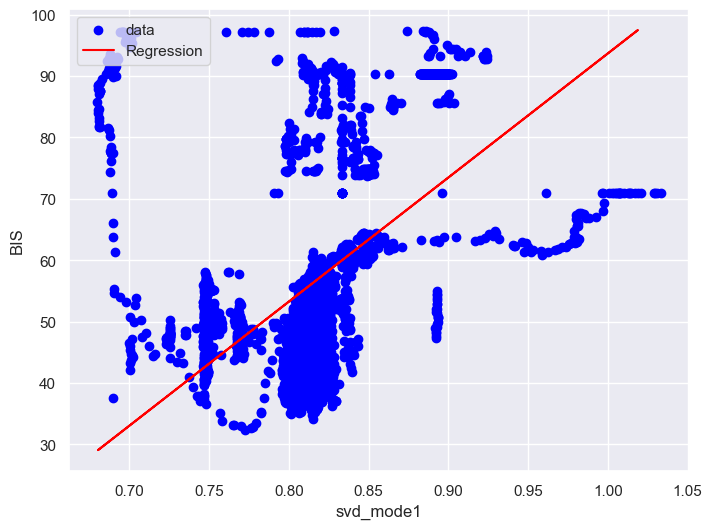

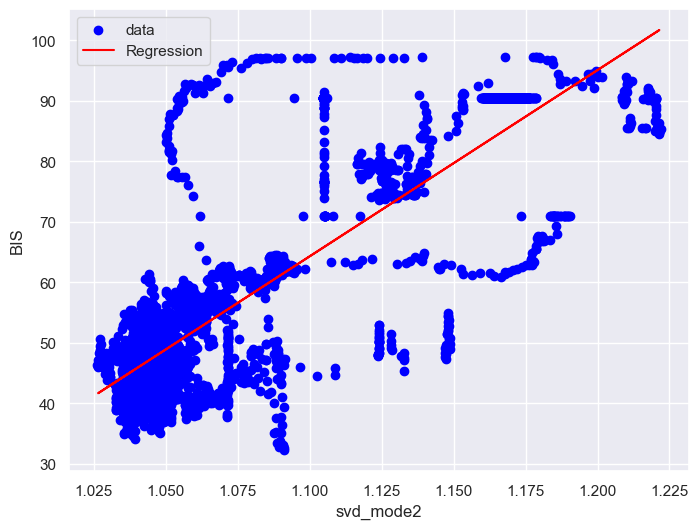

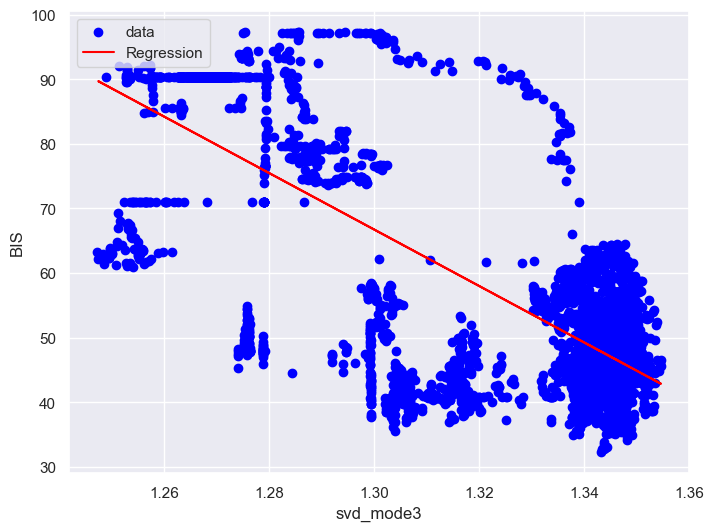

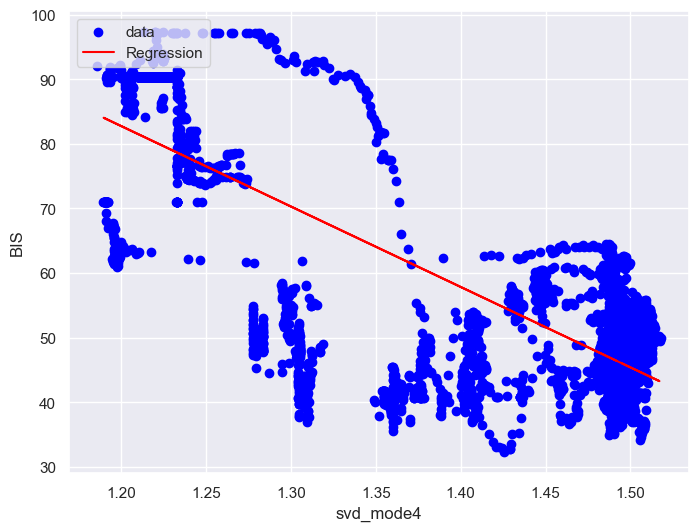

In [65]:
for column in df_svd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_svd, column)

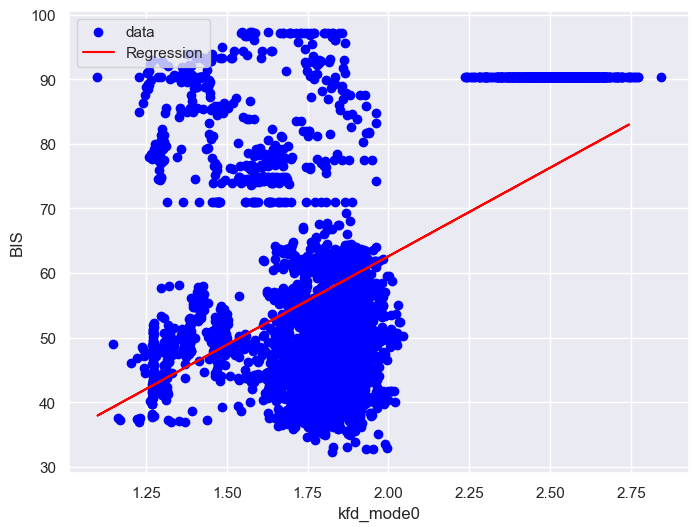

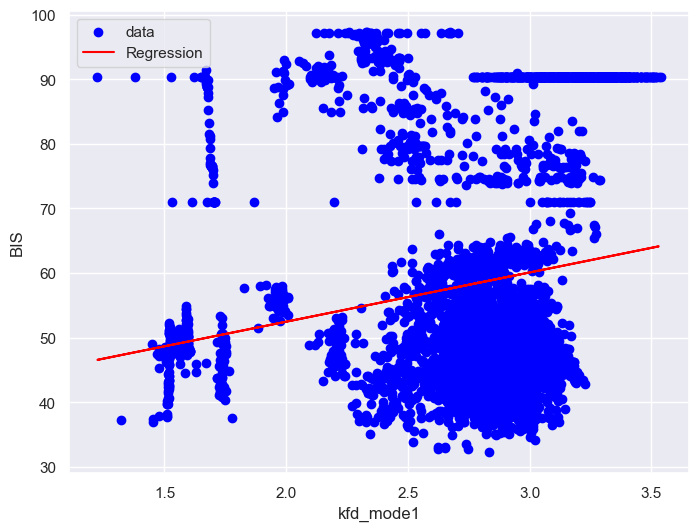

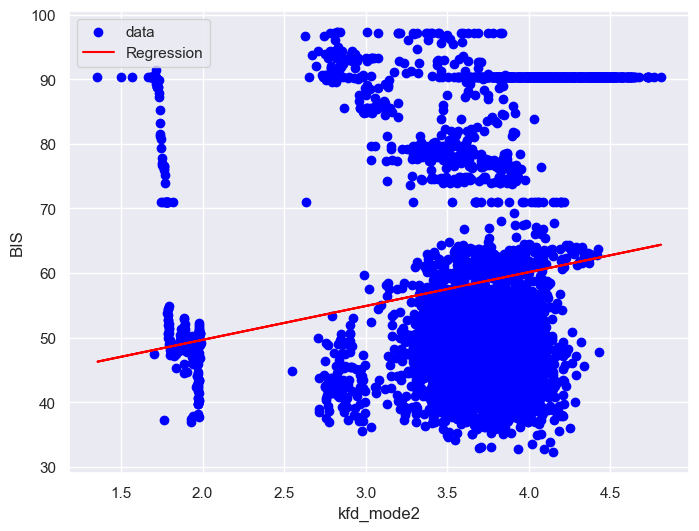

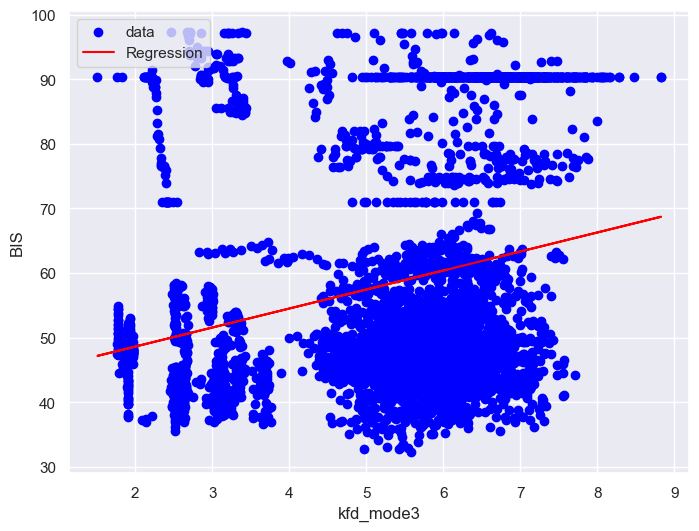

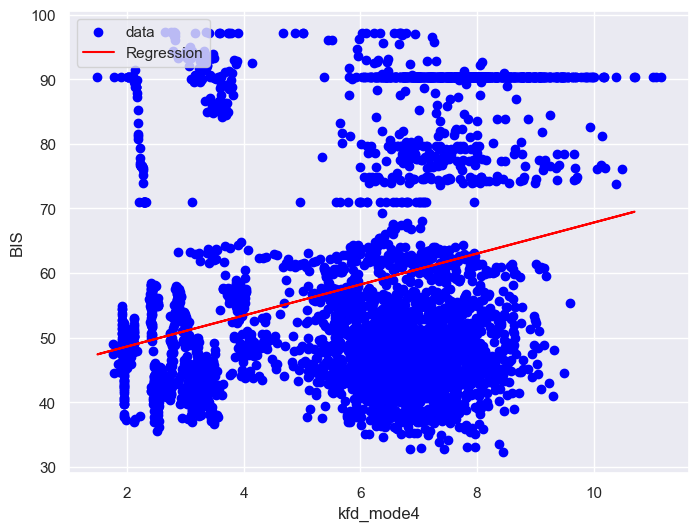

In [66]:
for column in df_kfd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_kfd, column)

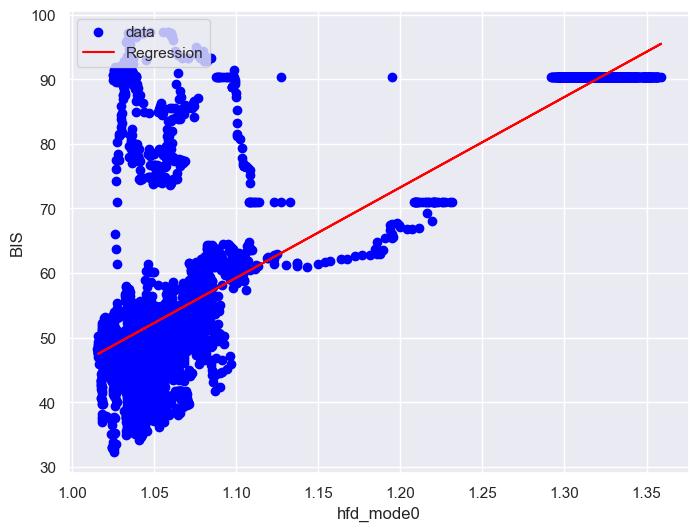

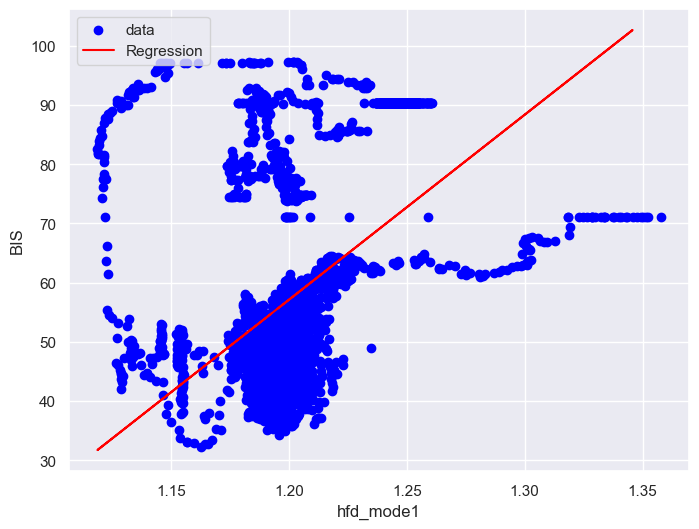

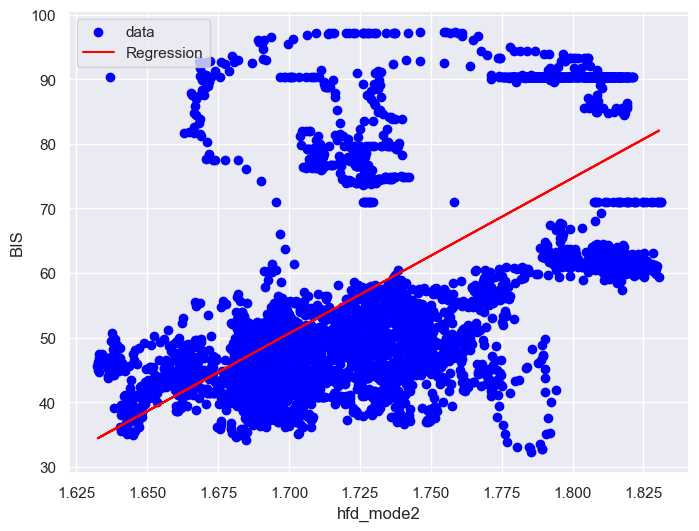

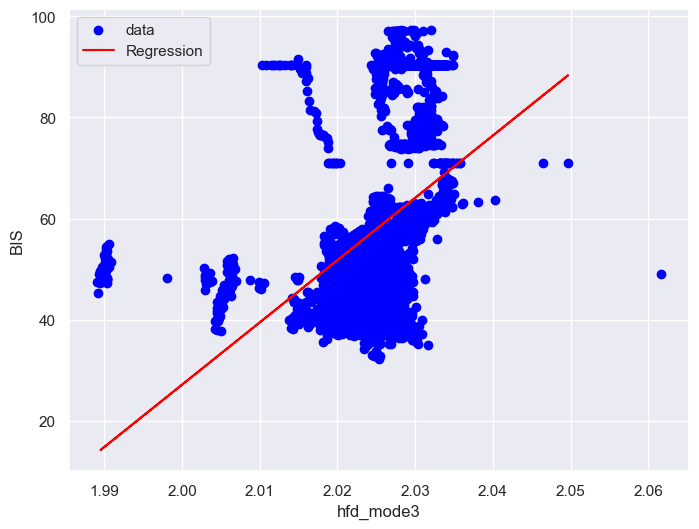

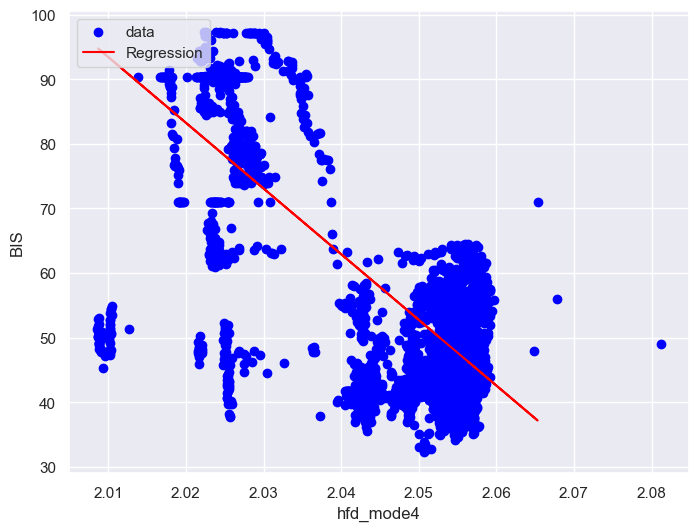

In [67]:
for column in df_hfd.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hfd, column)

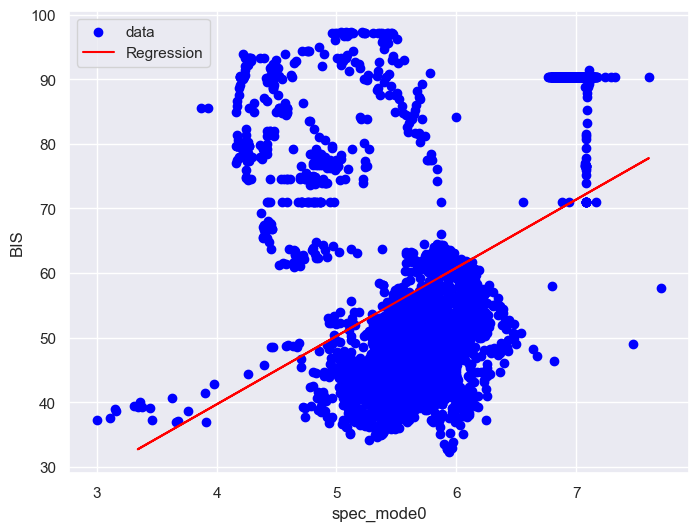

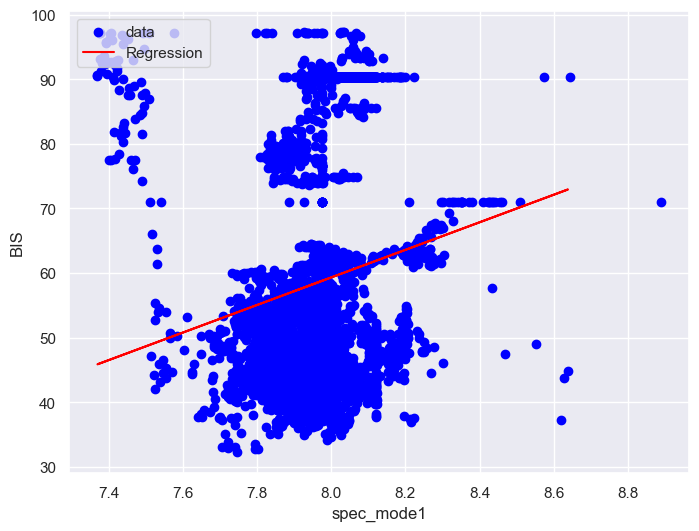

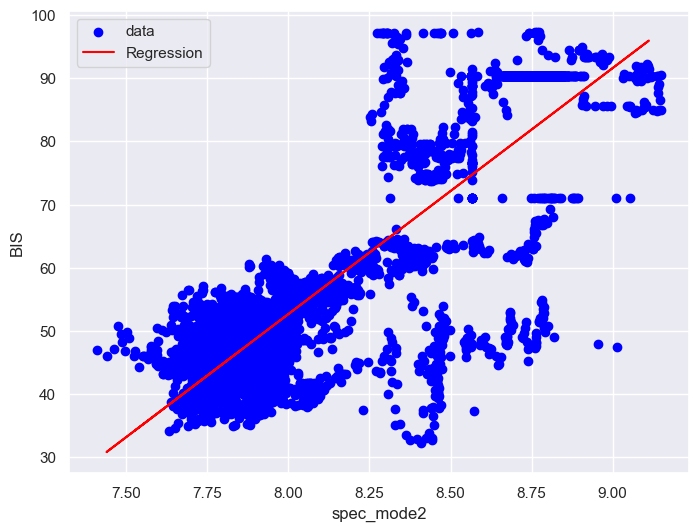

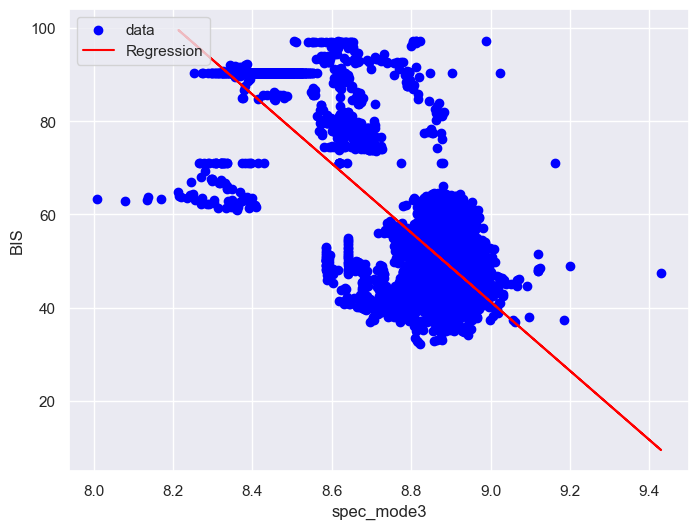

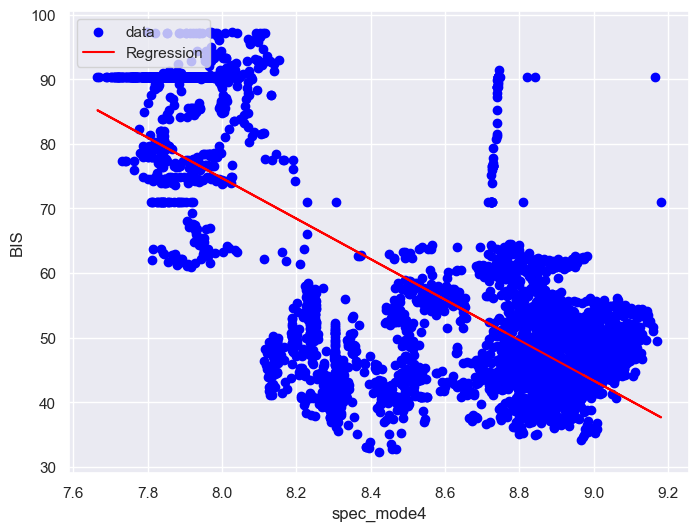

In [68]:
for column in df_spec.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_spec, column)

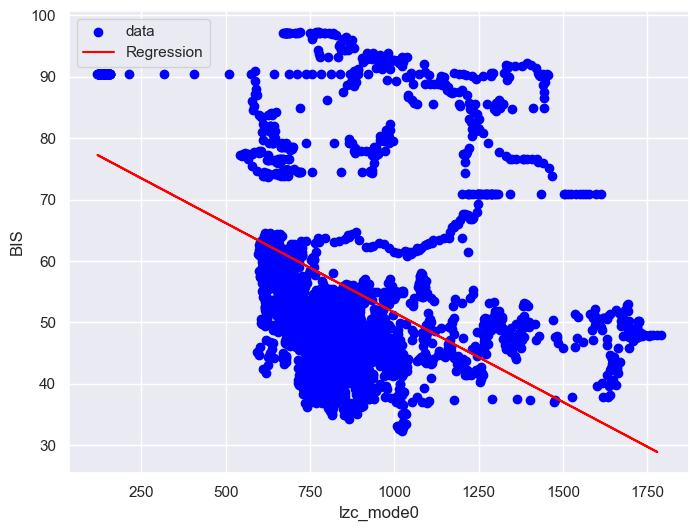

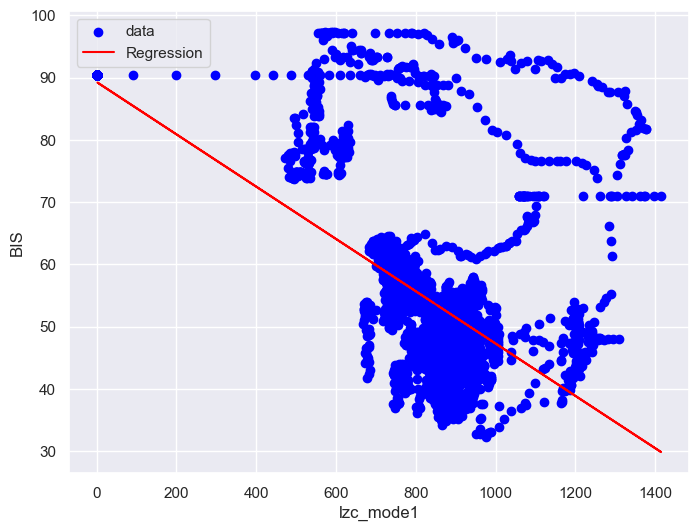

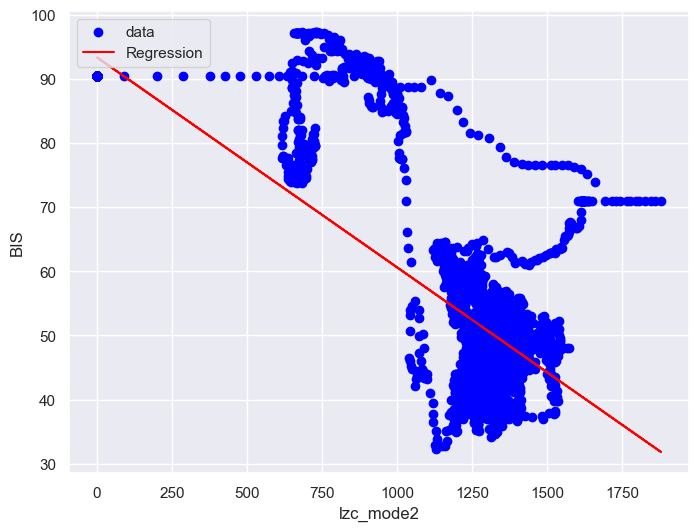

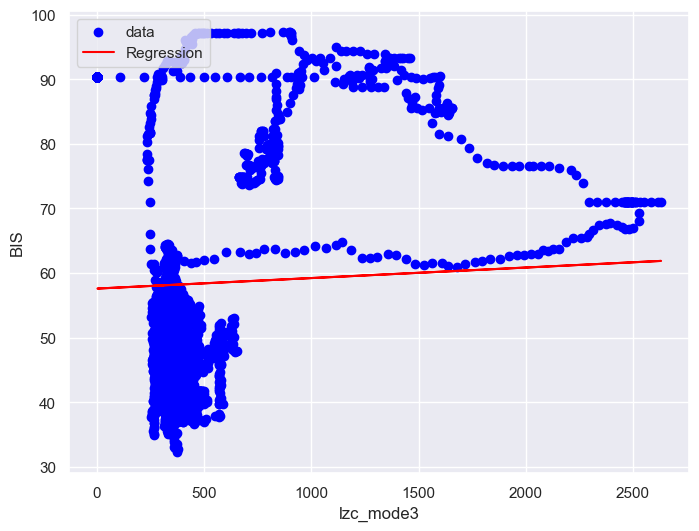

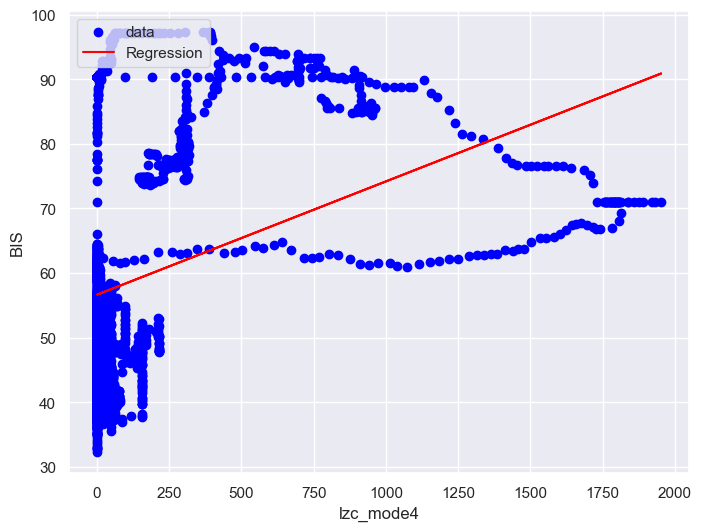

In [69]:
for column in df_lzc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_lzc, column)

In [109]:
# Metrics
total=pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})


In [110]:
sort_total=total.sort_values('Values', ascending=False)
sort_total

Metrics     Values
24  Perment_mode4_r2  84.249213
7       pet_mode2_r2  81.091265
22  Perment_mode2_r2  81.062725
8       pet_mode3_r2  80.929309
23  Perment_mode3_r2  80.211539
9       pet_mode4_r2  77.847107
29     Disp_mode4_r2  76.567758
32      svd_mode2_r2  75.430328
52      lzc_mode2_r2  72.593627
17       hc_mode2_r2  70.598108
47     spec_mode2_r2  67.987604
16       hc_mode1_r2  66.124222
12       hm_mode2_r2  66.108124
34      svd_mode4_r2  63.544835
28     Disp_mode3_r2  62.394699
5       pet_mode0_r2  61.498712
48     spec_mode3_r2  60.682689
20  Perment_mode0_r2  60.496271
33      svd_mode3_r2  59.383967
6       pet_mode1_r2  59.065363
21  Perment_mode1_r2  59.033757
59    dispm_mode4_r2  58.342874
13       hm_mode3_r2  57.676020
44      hfd_mode4_r2  57.124466
51      lzc_mode1_r2  56.212179
49     spec_mode4_r2  54.536722
40      hfd_mode0_r2  53.957678
18       hc_mode3_r2  53.407954
14       hm_mode4_r2  48.545630
10       hm_mode0_r2  46.207324
19       hc_mode4_r2  46.178370
42      hfd_mode2_r2  37.519190
0      detf_mode0_r2  33.944901
30      svd_mode0_r2  31.513501
50      lzc_mode0_r2  29.223300
58    dispm_mode3_r2  29.103320
31      svd_mode1_r2  26.167390
35      kfd_mode0_r2  23.608951
41      hfd_mode1_r2  23.581929
57    dispm_mode2_r2  22.772906
43      hfd_mode3_r2  20.905661
2      detf_mode2_r2  19.448126
55    dispm_mode0_r2  17.681554
45     spec_mode0_r2  16.764463
4      detf_mode4_r2  16.636975
25     Disp_mode0_r2  13.694570
11       hm_mode1_r2  13.513603
38      kfd_mode3_r2   7.883184
39      kfd_mode4_r2   7.056759
54      lzc_mode4_r2   6.800061
36      kfd_mode1_r2   3.654741
26     Disp_mode1_r2   3.035924
3      detf_mode3_r2   2.927405
37      kfd_mode2_r2   2.094407
46     spec_mode1_r2   2.091352
15       hc_mode0_r2   1.990090
56    dispm_mode1_r2   0.223427
1      detf_mode1_r2  -0.005009
53      lzc_mode3_r2  -0.061388
27     Disp_mode2_r2  -0.130202

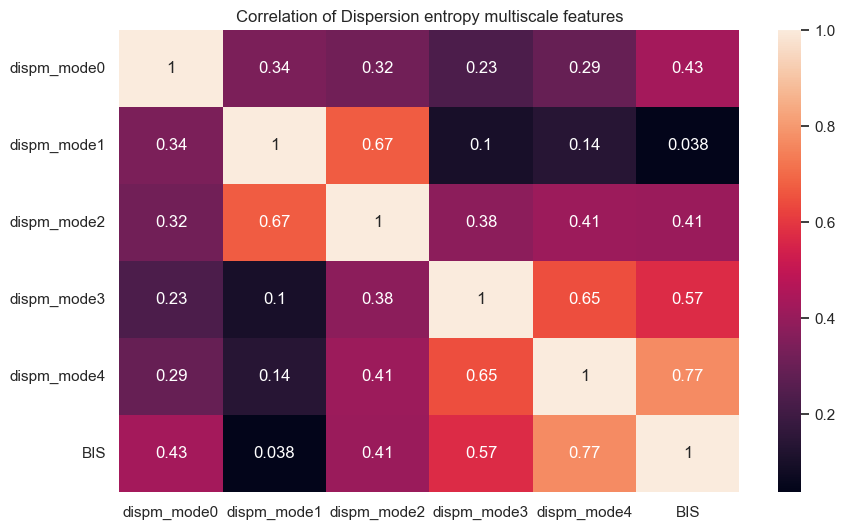

In [112]:
df_dispm=pd.read_csv('dispm_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_dispm.corr(), annot = True)
plt.title('Correlation of Dispersion entropy multiscale features')
plt.show()

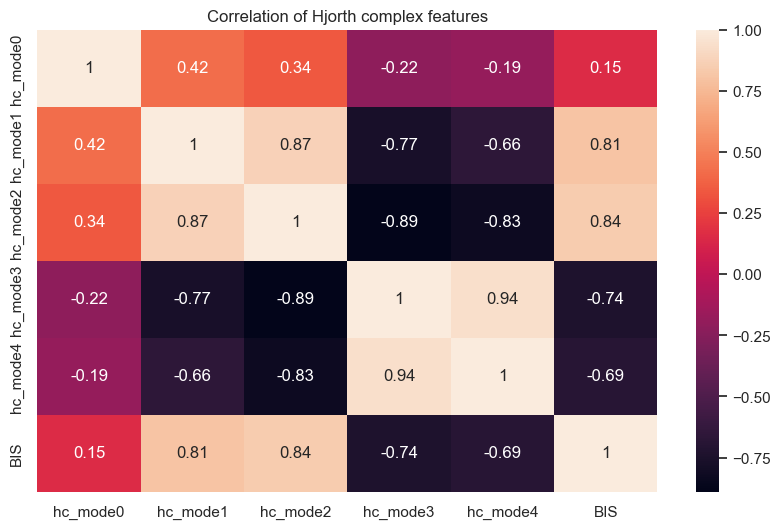

In [90]:
hc=pd.read_csv('hc_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(hc.corr(), annot = True)
plt.title('Correlation of Hjorth complex features')
plt.show()

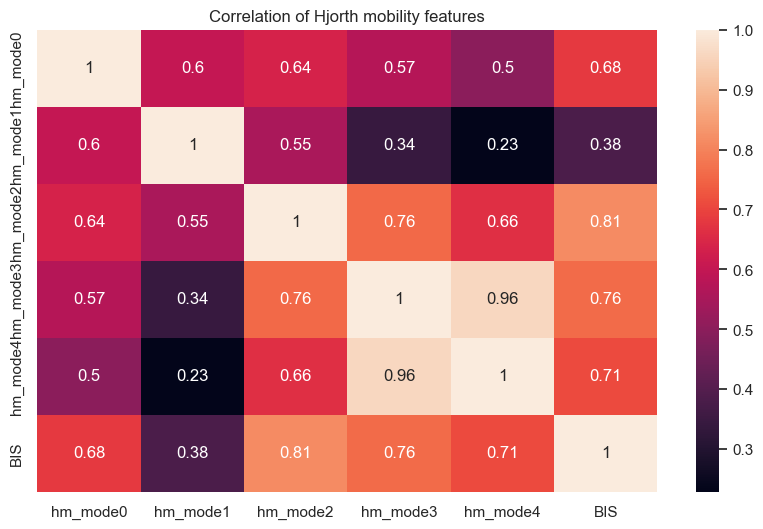

In [91]:
df_hm=pd.read_csv('hm_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_hm.corr(), annot = True)
plt.title('Correlation of Hjorth mobility features')
plt.show()

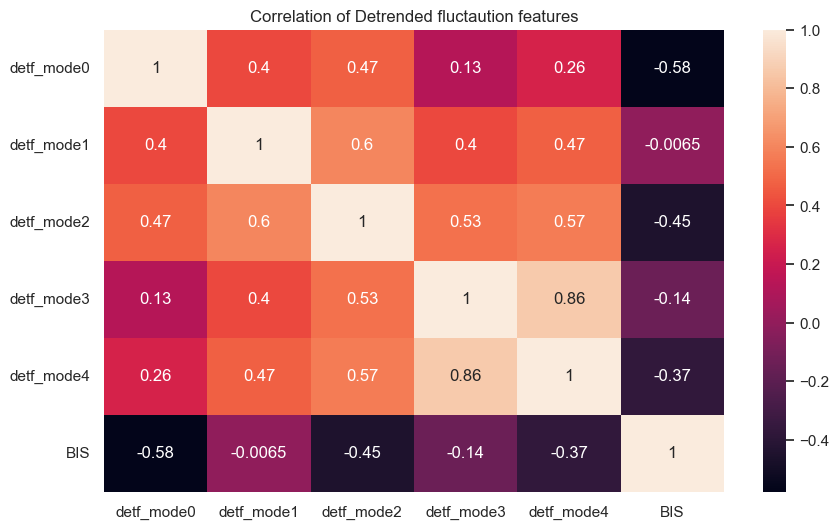

In [92]:
df_detf=pd.read_csv('detf_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_detf.corr(), annot = True)
plt.title('Correlation of Detrended fluctaution features')
plt.show()

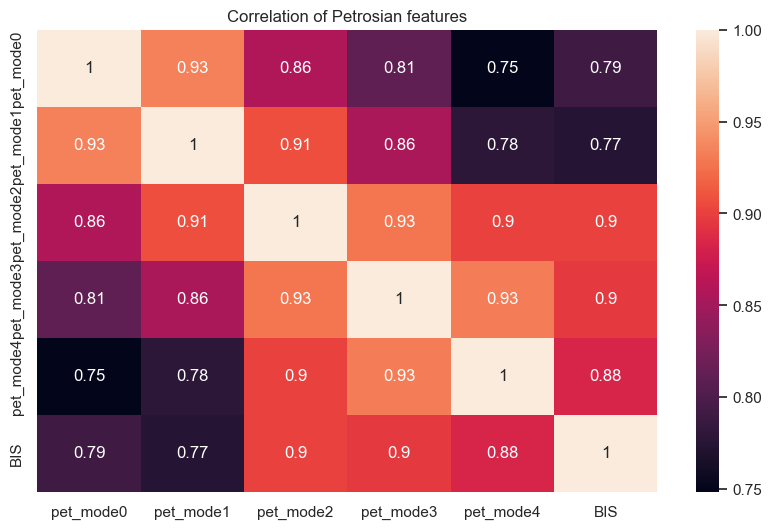

In [93]:
df_pet=pd.read_csv('pet_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_pet.corr(), annot = True)
plt.title('Correlation of Petrosian features')
plt.show()

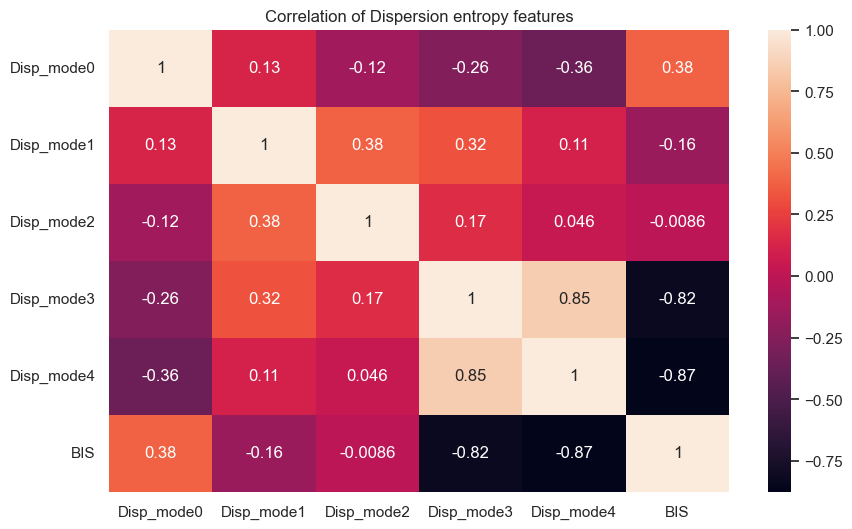

In [94]:
df_disp=pd.read_csv('disp_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_disp.corr(), annot = True)
plt.title('Correlation of Dispersion entropy features')
plt.show()

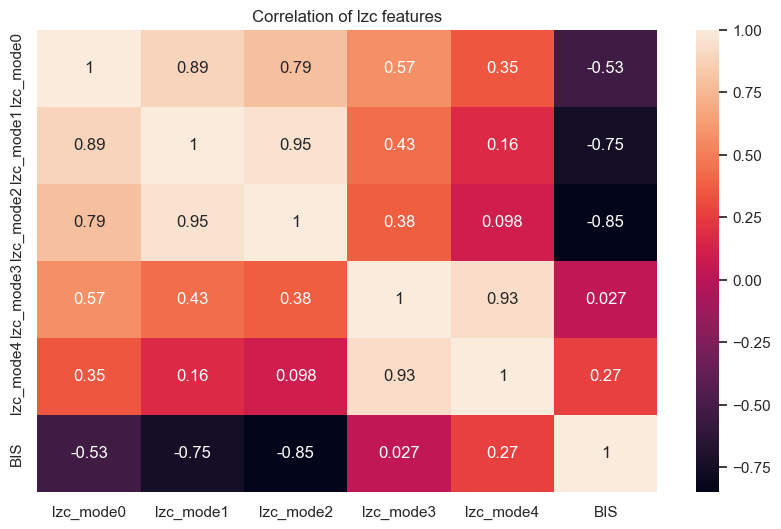

In [102]:
df_lzc=pd.read_csv('lzc_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_lzc.corr(), annot = True)
plt.title('Correlation of lzc features')
plt.show()

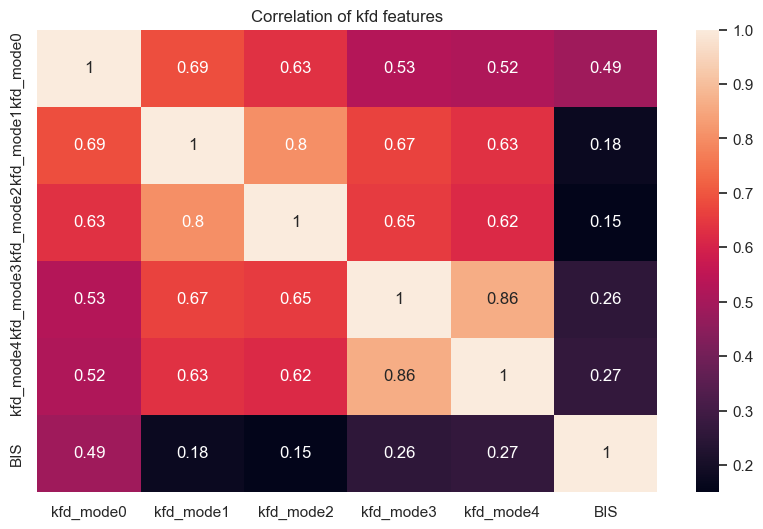

In [103]:
df_kfd=pd.read_csv('kfd_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_kfd.corr(), annot = True)
plt.title('Correlation of kfd features')
plt.show()

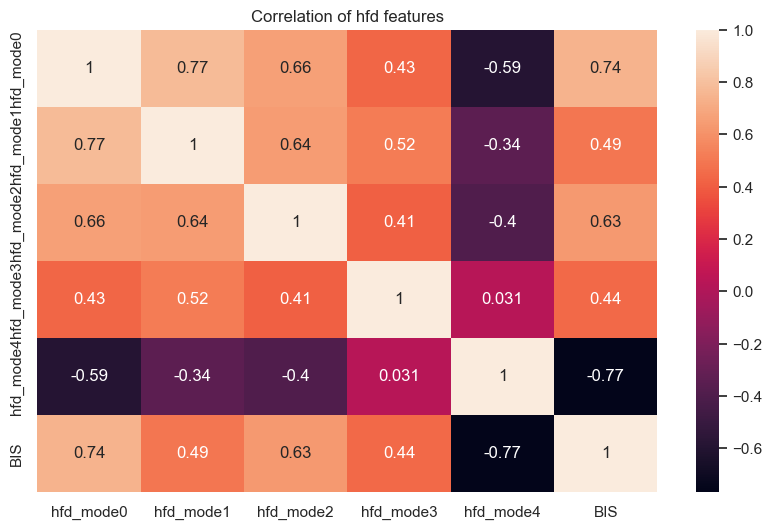

In [113]:
df_hfd=pd.read_csv('hfd_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_hfd.corr(), annot = True)
plt.title('Correlation of hfd features')
plt.show()

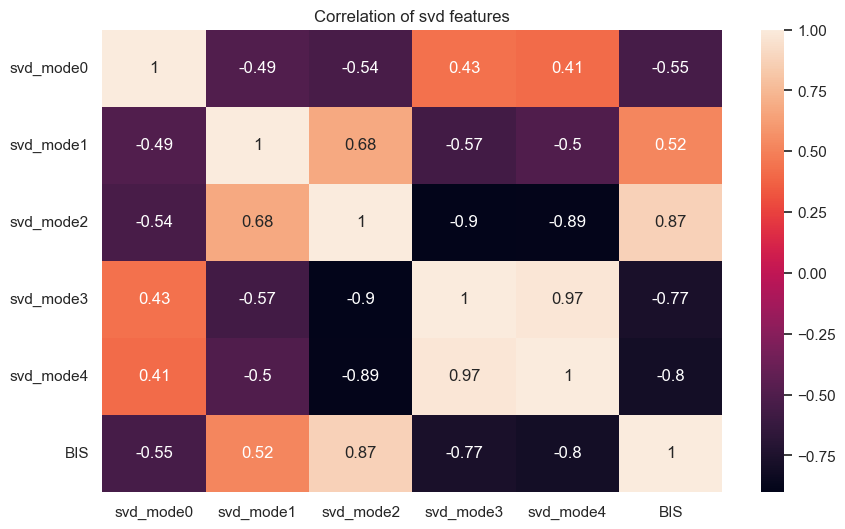

In [104]:
df_svd=pd.read_csv('svd_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_svd.corr(), annot = True)
plt.title('Correlation of svd features')
plt.show()

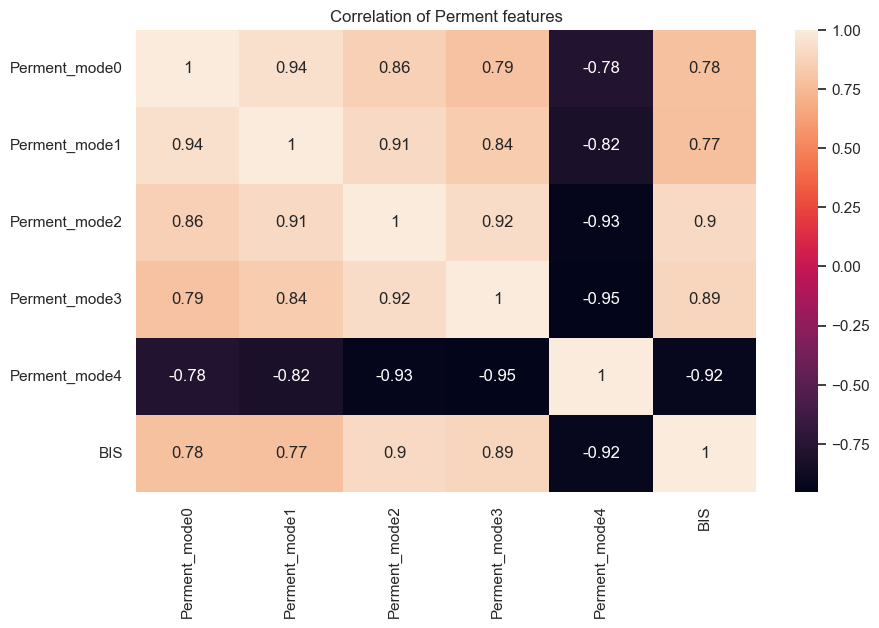

In [105]:
df_perm=pd.read_csv('perm_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_perm.corr(), annot = True)
plt.title('Correlation of Perment features')
plt.show()

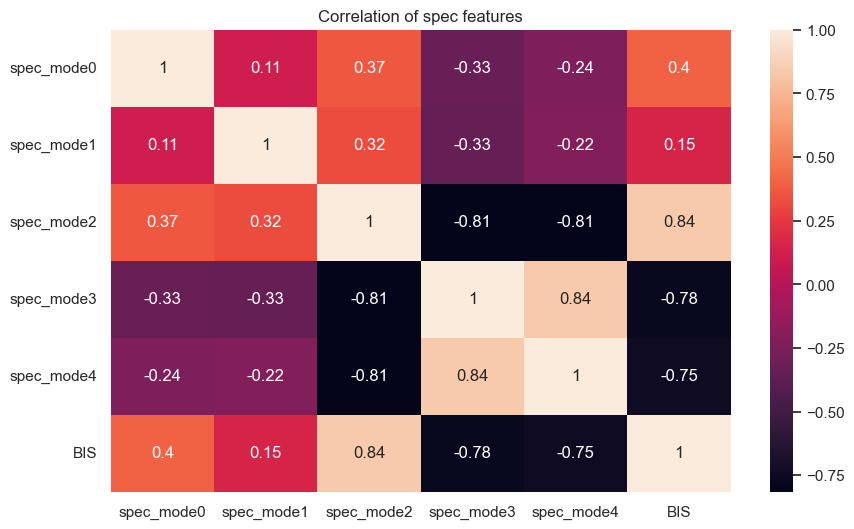

In [106]:
df_spec=pd.read_csv('spec_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(df_spec.corr(), annot = True)
plt.title('Correlation of spec features')
plt.show()

### Combine the best features in a dataframe

In [114]:
data_78=pd.DataFrame({'Perment_mode4': resultsp_4,'Pet_mode3': resultspet_3, 'disp_mode4': resultsd_4, 'dispm_mode4':resultsdispm_4, 
                  'lzc_mode2':resultslzc_2, 'svd_mode2':resultsvd_2, 'spec_mode2':resultspec_2, 'hc_mode2':resultshc_2, 'hm_mode2':resultshm_2,
                  'hfd_mode4':resultshfd_4})
data_78['BIS']=bis_windows
data_78

Perment_mode4  Pet_mode3  disp_mode4  dispm_mode4  lzc_mode2  svd_mode2  \
0          2.579941   1.021758    1.650478     1.964798        662   1.137937   
1          2.580091   1.021764    1.655998     1.966469        666   1.139575   
2          2.580149   1.021780    1.653529     1.966705        664   1.140382   
3          2.580254   1.021796    1.657103     1.963155        660   1.140595   
4          2.580337   1.021796    1.660104     1.964489        662   1.140730   
...             ...        ...         ...          ...        ...        ...   
4060       2.580858   1.021916    1.708463     1.971139          2   1.174044   
4061       2.580827   1.021916    1.709664     1.967803          2   1.173289   
4062       2.580822   1.021899    1.709813     1.971203          2   1.173775   
4063       2.580863   1.021861    1.708174     1.969209          2   1.173565   
4064       2.580909   1.021850    1.702793     1.968979          2   1.175290   

      spec_mode2  hc_mode2  hm_mode2  hfd_mode4   BIS  
0       8.499814  1.156704  0.608682   2.026296  90.9  
1       8.522111  1.157650  0.610458   2.026370  89.3  
2       8.537083  1.156557  0.611846   2.025578  88.1  
3       8.537430  1.156233  0.612034   2.025724  87.0  
4       8.562505  1.155354  0.612545   2.025941  87.2  
...          ...       ...       ...        ...   ...  
4060    8.755532  1.137938  0.663846   2.025742  90.4  
4061    8.774293  1.138101  0.662613   2.026147  90.4  
4062    8.767233  1.140903  0.661795   2.027126  90.4  
4063    8.774087  1.141326  0.661457   2.026691  90.4  
4064    8.810083  1.141022  0.663472   2.026055  90.4  

[4065 rows x 11 columns]

In [116]:
data_78.to_csv('data_78.csv', index=False)

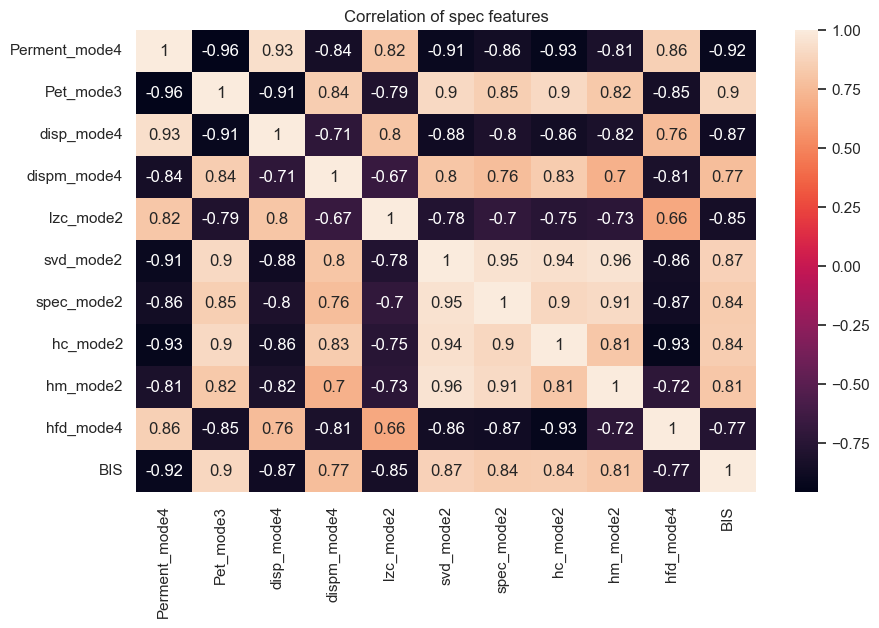

In [118]:
data_78=pd.read_csv('data_78.csv')
plt.figure(figsize=(10,6))
sns.heatmap(data_78.corr(), annot = True)
plt.title('Correlation of spec features')
plt.show()

In [120]:
features=['Pet_mode3', 'disp_mode4', 'hc_mode2']

In [123]:
X=data_78[features]
y=data_78['BIS']

In [124]:


mmm = LinearRegression(n_jobs=-1).fit(X, y)
    
# Predictions
y_pre = mmm.predict(X)
    
# Show the score and r2
mse = mean_squared_error(y, y_pre)
r2 = r2_score(y, y_pre)
    
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mmm.coef_,mmm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)

Multiple regression model Slope = [27267.26973898   -79.19542871    56.04652451], and intercept =-27711.957828677037
R_Squared_value for the multiple regression model:  82.4669162169126


In [130]:
mse = mean_squared_error(y, y_pre)
print('mse: ', mse)

mse:  58.44112253950331


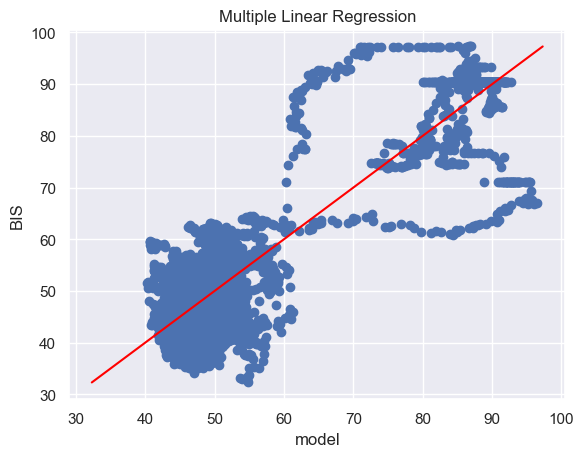

In [128]:
x1=data_78['Pet_mode3']
x2=data_78['disp_mode4']
x3=data_78['hc_mode2']
y_plot =mmm.coef_[0]*x1+mmm.coef_[1]*x2+mmm.coef_[2]*x3 + mmm.intercept_

plt.scatter(y_plot, y)
plt.plot( [y.min(), y.max()], [y.min(), y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


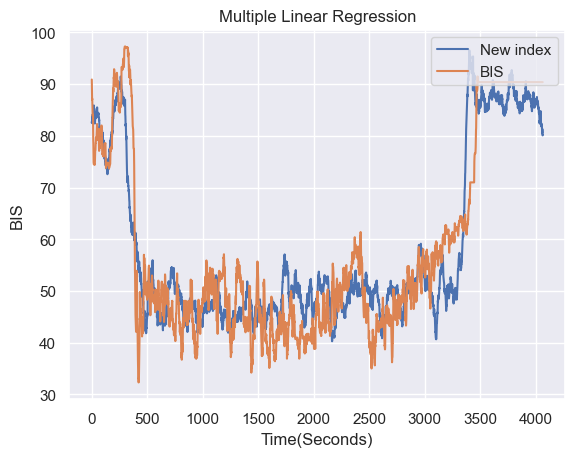

In [129]:
plt.plot(y_plot, label='New index')
plt.plot(y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [131]:
features=['Perment_mode4', 'dispm_mode4', 'hm_mode2']
X=data_78[features]
y=data_78['BIS']



mmm = LinearRegression(n_jobs=-1).fit(X, y)
    
# Predictions
y_pre = mmm.predict(X)
    
# Show the score and r2
mse = mean_squared_error(y, y_pre)
r2 = r2_score(y, y_pre)
    
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mmm.coef_,mmm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)
print('mse: ', mse)

Multiple regression model Slope = [-6548.88269624   -52.28010714   101.507379  ], and intercept =17017.9585199076
R_Squared_value for the multiple regression model:  85.71420239890122
mse:  47.617296449908515


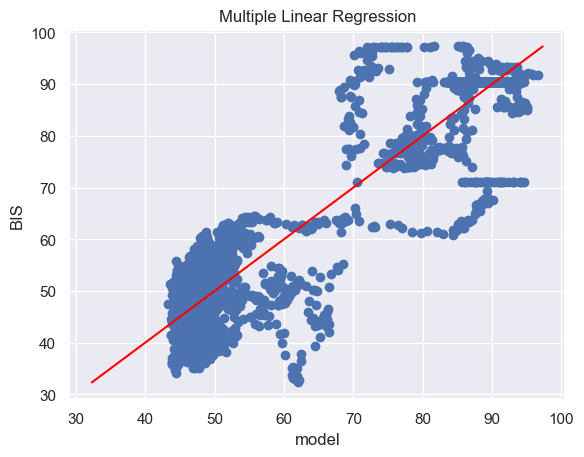

In [132]:
x1=data_78['Perment_mode4']
x2=data_78['dispm_mode4']
x3=data_78['hm_mode2']
y_plot =mmm.coef_[0]*x1+mmm.coef_[1]*x2+mmm.coef_[2]*x3 + mmm.intercept_

plt.scatter(y_plot, y)
plt.plot( [y.min(), y.max()], [y.min(), y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


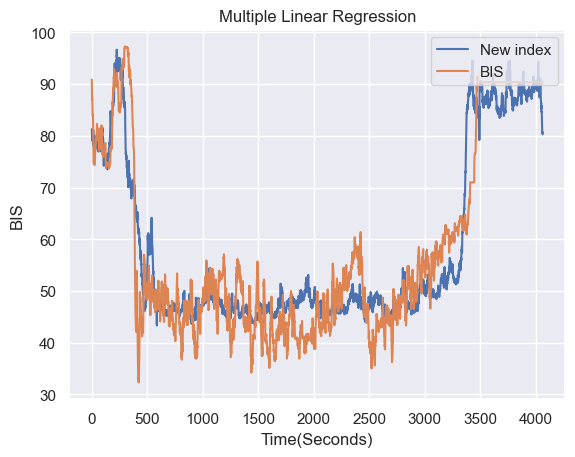

In [133]:
plt.plot(y_plot, label='New index')
plt.plot(y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [138]:
features=['Perment_mode4', 'spec_mode2', 'hfd_mode4']
X=data_78[features]
y=data_78['BIS']



mmm = LinearRegression(n_jobs=-1).fit(X, y)
    
# Predictions
y_pre = mmm.predict(X)
    
# Show the score and r2
mse = mean_squared_error(y, y_pre)
r2 = r2_score(y, y_pre)
    
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mmm.coef_,mmm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)
print('mse: ', mse)

Multiple regression model Slope = [-7234.27512991    13.75872647   310.15727134], and intercept =18000.111118479777
R_Squared_value for the multiple regression model:  86.19584765716995
mse:  46.011880659549625


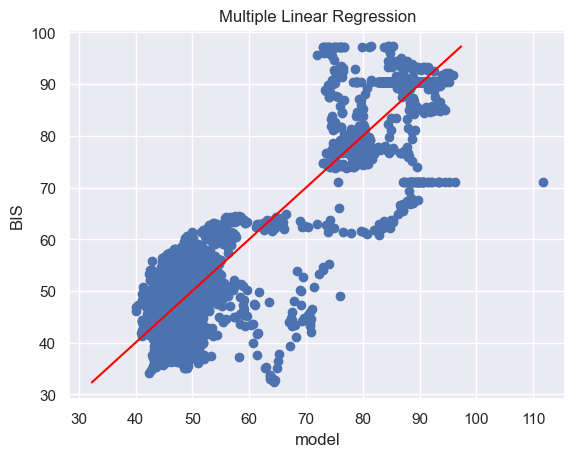

In [139]:
x1=data_78['Perment_mode4']
x2=data_78['spec_mode2']
x3=data_78['hfd_mode4']
y_plot =mmm.coef_[0]*x1+mmm.coef_[1]*x2+mmm.coef_[2]*x3 + mmm.intercept_

plt.scatter(y_plot, y)
plt.plot( [y.min(), y.max()], [y.min(), y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


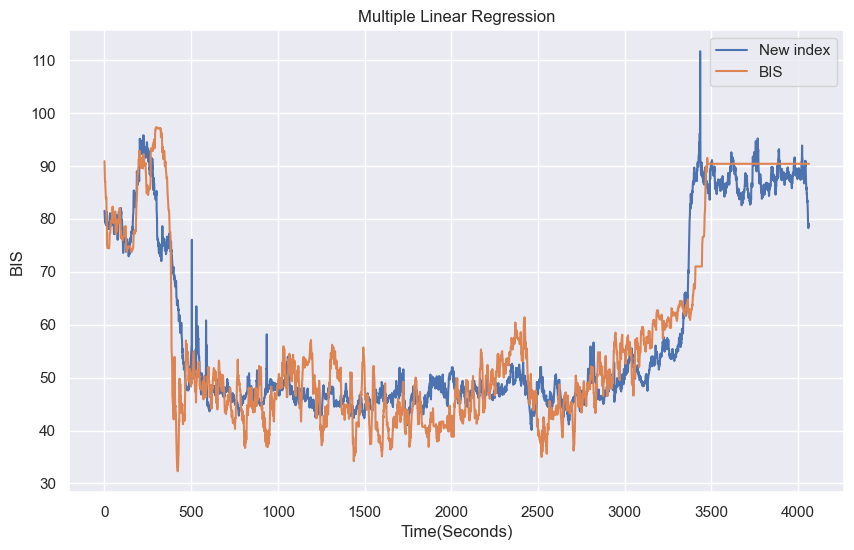

In [141]:
plt.figure(figsize=(10,6))
plt.plot(y_plot, label='New index')
plt.plot(y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [157]:
features=['Perment_mode4', 'lzc_mode2', 'spec_mode2']
X=data_78[features]
y=data_78['BIS']



mmm = LinearRegression(n_jobs=-1).fit(X, y)
    
# Predictions
y_pre = mmm.predict(X)
    
# Show the score and r2
mse = mean_squared_error(y, y_pre)
r2 = r2_score(y, y_pre)
    
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mmm.coef_,mmm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)
print('mse: ', mse)

Multiple regression model Slope = [-4.33365663e+03 -1.15495500e-02  8.46398352e+00], and intercept =11196.679092577953
R_Squared_value for the multiple regression model:  88.0911788288067
mse:  39.6943792647631


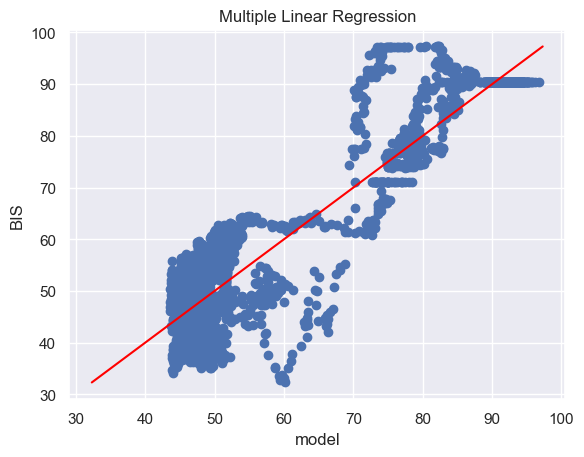

In [158]:
x1=data_78['Perment_mode4']
x2=data_78['lzc_mode2']
x3=data_78['spec_mode2']
y_plot =mmm.coef_[0]*x1+mmm.coef_[1]*x2+mmm.coef_[2]*x3 + mmm.intercept_

plt.scatter(y_plot, y)
plt.plot( [y.min(), y.max()], [y.min(), y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


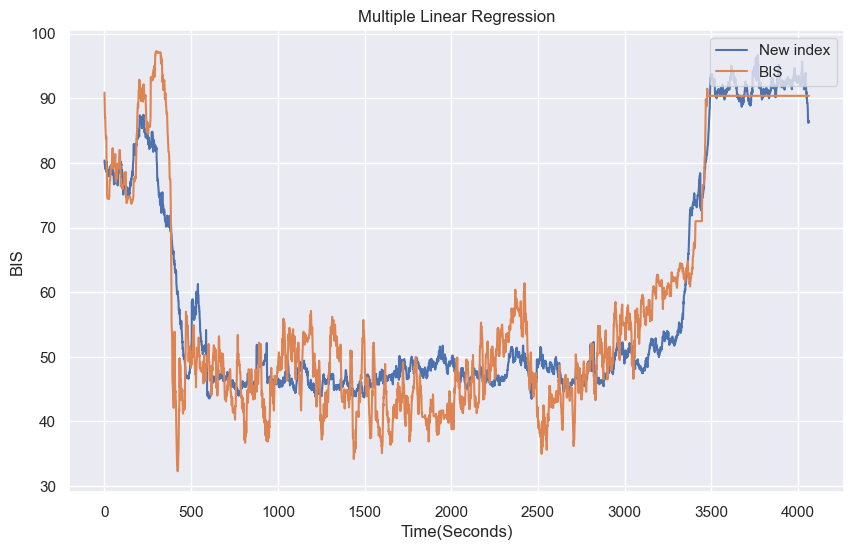

In [159]:
plt.figure(figsize=(10,6))
plt.plot(y_plot, label='New index')
plt.plot(y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [171]:
features=['Perment_mode4', 'lzc_mode2', 'spec_mode2']
X=data_78[features]
y=data_78['BIS']



mmm = LinearRegression(n_jobs=-1).fit(X, y)
    
# Predictions
y_pre = mmm.predict(X)
    
# Show the score and r2
mse = mean_squared_error(y, y_pre)
r2 = r2_score(y, y_pre)
    
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mmm.coef_,mmm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)
print('mse: ', mse)

Multiple regression model Slope = [-4.33365663e+03 -1.15495500e-02  8.46398352e+00], and intercept =11196.679092577953
R_Squared_value for the multiple regression model:  88.0911788288067
mse:  39.6943792647631


### Machine learning

In [225]:
features=['Perment_mode4', 'hm_mode2', 'disp_mode4']
X=data_78[features]
y=data_78['BIS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [242]:
svr_regressor = SVR()

# Define the hyperparameters
param_grid = {
    'kernel': ['poly', 'rbf'],
    'degree':[1, 3, 5],
    'gamma':['scale', 'auto'],
    'C': [10, 30, 40, 50],  
    'epsilon': [0.3, 0.5, 0.7],
}

start = time.time()

print(f"Took{duration} seconds")

grid_search = GridSearchCV(svr_regressor, param_grid, cv=10, scoring='r2', verbose=True)
grid_search.fit(X_train, y_train) 
best_svr_model = grid_search.best_estimator_

duration  = (time.time() - start)

y_pred = best_svr_model.predict(X_val) #prediction on the test data

# Model evaluation
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
train_score = grid_search.score(X_train, y_train)

print("Best Support Vector Regressor Model:", best_svr_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Train score: ", train_score)



Took2.754688262939453 seconds
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


KeyboardInterrupt: 

In [243]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Generate some random data for demonstration


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the scaled training data
rf_regressor.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred = rf_regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Mean Squared Error: 14.77
R-squared: 0.96


In [227]:
data_92=pd.read_csv('data_92.csv')

In [245]:
features=['Perment_mode4', 'hm_mode2', 'disp_mode4']
Xx=data_92[features]
yy=data_92['BIS']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
Xx_t = scaler.transform(Xx)

In [246]:
y_pred = rf.predict(Xx_t)

test_score=rf.score(Xx_t, yy)
#best_rf_model = grid_search.best_estimator_


mse = mean_squared_error(yy, y_pred)
r2 = r2_score(yy, y_pred)
correlation_coefficient, _ = pearsonr(yy, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
#print('The model_score is', model_score)
print("train score is: ", train_score)
print('test score is: ', test_score)

Mean Squared Error (MSE): 1898.0013696370718
R-squared (R2): -10.870551981088571
train score is:  0.9935963218742407
test score is:  -10.870551981088571


In [247]:
y_pred

array([87.385, 87.385, 87.385, ..., 84.817, 84.817, 84.817])

In [248]:
yy

0       92.8
1       93.3
2       93.8
3       94.5
4       94.7
        ... 
4060    94.9
4061    94.9
4062    95.1
4063    95.0
4064    92.4
Name: BIS, Length: 4065, dtype: float64

In [196]:
data_112=pd.read_csv('data_112.csv')
data_112

Perment_mode4  Pet_mode3  disp_mode4  lzc_mode2  spec_mode2  hc_mode2  \
0           2.580879   1.014567    1.735575       1660    8.517853  1.086165   
1           2.580996   1.014601    1.735504       1662    8.518327  1.086168   
2           2.580844   1.014584    1.738717       1620    8.506681  1.084083   
3           2.580874   1.014590    1.744474       1569    8.509896  1.083949   
4           2.581080   1.014595    1.738160       1552    8.512643  1.083330   
...              ...        ...         ...        ...         ...       ...   
10060       2.579638   1.014498    1.709512       2481    8.511270  1.083193   
10061       2.579599   1.014481    1.715073       2522    8.522849  1.082977   
10062       2.579237   1.014453    1.716514       2560    8.521313  1.082974   
10063       2.578603   1.014595    1.727131       2574    8.521877  1.082971   
10064       2.578542   1.014584    1.723201       2613    8.524720  1.083147   

       hm_mode2   BIS  
0      0.602878  84.0  
1      0.602876  85.0  
2      0.601465  85.0  
3      0.601553  85.0  
4      0.601020  85.0  
...         ...   ...  
10060  0.617963  92.0  
10061  0.617823  92.0  
10062  0.617792  92.0  
10063  0.617800  92.0  
10064  0.617587  92.0  

[10065 rows x 8 columns]

In [240]:
features=['Perment_mode4', 'hm_mode2', 'disp_mode4']
Xxx=data_112[features]
yyy=data_112['BIS']

In [241]:
y_pred = rf.predict(Xxx)

test_score=rf.score(Xxx, yyy)
#best_rf_model = rf.best_estimator_


mse = mean_squared_error(yyy, y_pred)
r2 = r2_score(yyy, y_pred)
correlation_coefficient, _ = pearsonr(yyy, y_pred)

#print("Best Random Forest Regressor Model:", best_rf_model)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
#print('The model_score is', model_score)
print("train score is: ", train_score)
print('test score is: ', test_score)

Mean Squared Error (MSE): 200.97662508222308
R-squared (R2): -0.21838246271599648
train score is:  0.9935963218742407
test score is:  -0.21838246271599648


In [206]:
data_112

Perment_mode4  Pet_mode3  disp_mode4  lzc_mode2  spec_mode2  hc_mode2  \
0           2.580879   1.014567    1.735575       1660    8.517853  1.086165   
1           2.580996   1.014601    1.735504       1662    8.518327  1.086168   
2           2.580844   1.014584    1.738717       1620    8.506681  1.084083   
3           2.580874   1.014590    1.744474       1569    8.509896  1.083949   
4           2.581080   1.014595    1.738160       1552    8.512643  1.083330   
...              ...        ...         ...        ...         ...       ...   
10060       2.579638   1.014498    1.709512       2481    8.511270  1.083193   
10061       2.579599   1.014481    1.715073       2522    8.522849  1.082977   
10062       2.579237   1.014453    1.716514       2560    8.521313  1.082974   
10063       2.578603   1.014595    1.727131       2574    8.521877  1.082971   
10064       2.578542   1.014584    1.723201       2613    8.524720  1.083147   

       hm_mode2   BIS  
0      0.602878  84.0  
1      0.602876  85.0  
2      0.601465  85.0  
3      0.601553  85.0  
4      0.601020  85.0  
...         ...   ...  
10060  0.617963  92.0  
10061  0.617823  92.0  
10062  0.617792  92.0  
10063  0.617800  92.0  
10064  0.617587  92.0  

[10065 rows x 8 columns]

In [207]:
data_92

Perment_mode4  Pet_mode3  disp_mode4  lzc_mode2  spec_mode2  hc_mode2  \
0          2.581252   1.020843    1.753173        912    8.880798  1.157700   
1          2.581324   1.020815    1.751986        902    8.894031  1.157991   
2          2.581382   1.020783    1.755460        906    8.886058  1.158254   
3          2.581440   1.020766    1.751539        906    8.896606  1.160795   
4          2.581600   1.020761    1.752087        921    8.901805  1.162138   
...             ...        ...         ...        ...         ...       ...   
4060       2.581115   1.020881    1.791967        732    9.067322  1.120550   
4061       2.581103   1.020903    1.785097        724    9.067316  1.120547   
4062       2.580895   1.020897    1.778436        719    9.067003  1.120539   
4063       2.580786   1.020908    1.775863        712    9.067279  1.120538   
4064       2.580905   1.020919    1.771321        700    9.067665  1.120536   

      hm_mode2   BIS  
0     0.554721  92.8  
1     0.555489  93.3  
2     0.556682  93.8  
3     0.556957  94.5  
4     0.557220  94.7  
...        ...   ...  
4060  0.621085  94.9  
4061  0.621083  94.9  
4062  0.621080  95.1  
4063  0.621075  95.0  
4064  0.621072  92.4  

[4065 rows x 8 columns]

In [208]:
data_78

Perment_mode4  Pet_mode3  disp_mode4  dispm_mode4  lzc_mode2  svd_mode2  \
0          2.579941   1.021758    1.650478     1.964798        662   1.137937   
1          2.580091   1.021764    1.655998     1.966469        666   1.139575   
2          2.580149   1.021780    1.653529     1.966705        664   1.140382   
3          2.580254   1.021796    1.657103     1.963155        660   1.140595   
4          2.580337   1.021796    1.660104     1.964489        662   1.140730   
...             ...        ...         ...          ...        ...        ...   
4060       2.580858   1.021916    1.708463     1.971139          2   1.174044   
4061       2.580827   1.021916    1.709664     1.967803          2   1.173289   
4062       2.580822   1.021899    1.709813     1.971203          2   1.173775   
4063       2.580863   1.021861    1.708174     1.969209          2   1.173565   
4064       2.580909   1.021850    1.702793     1.968979          2   1.175290   

      spec_mode2  hc_mode2  hm_mode2  hfd_mode4   BIS  
0       8.499814  1.156704  0.608682   2.026296  90.9  
1       8.522111  1.157650  0.610458   2.026370  89.3  
2       8.537083  1.156557  0.611846   2.025578  88.1  
3       8.537430  1.156233  0.612034   2.025724  87.0  
4       8.562505  1.155354  0.612545   2.025941  87.2  
...          ...       ...       ...        ...   ...  
4060    8.755532  1.137938  0.663846   2.025742  90.4  
4061    8.774293  1.138101  0.662613   2.026147  90.4  
4062    8.767233  1.140903  0.661795   2.027126  90.4  
4063    8.774087  1.141326  0.661457   2.026691  90.4  
4064    8.810083  1.141022  0.663472   2.026055  90.4  

[4065 rows x 11 columns]

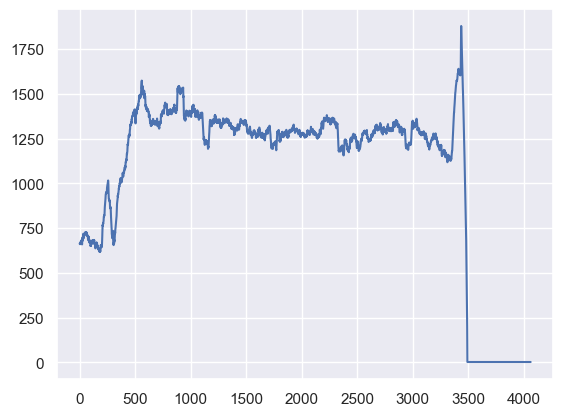

In [219]:
plt.plot(data_78['lzc_mode2'])

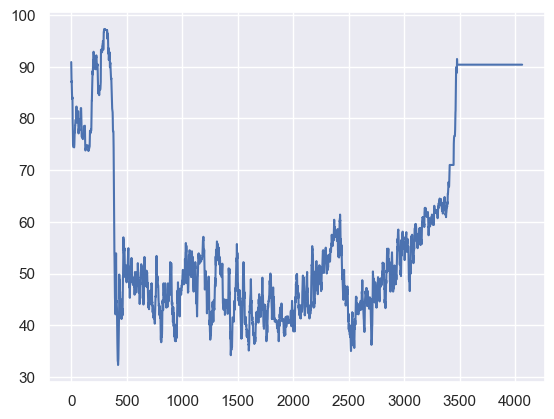

In [222]:
plt.plot(data_78['BIS'])

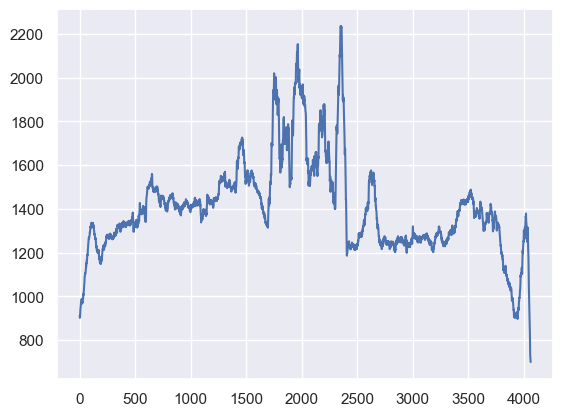

In [220]:
plt.plot(data_92['lzc_mode2'])

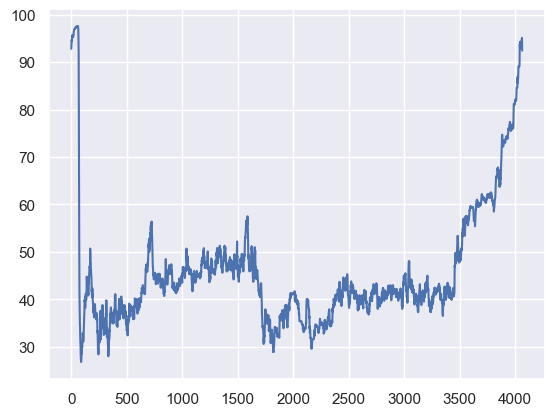

In [223]:
plt.plot(data_92['BIS'])

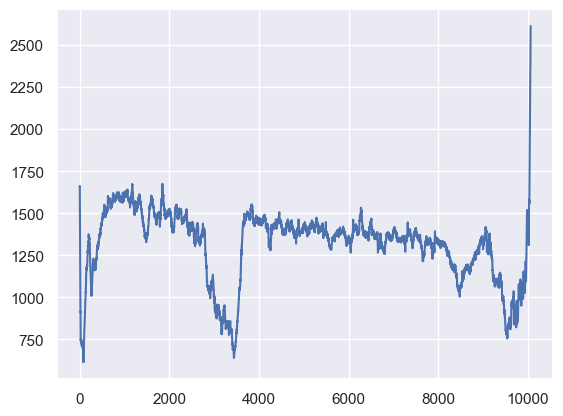

In [221]:
plt.plot(data_112['lzc_mode2'])

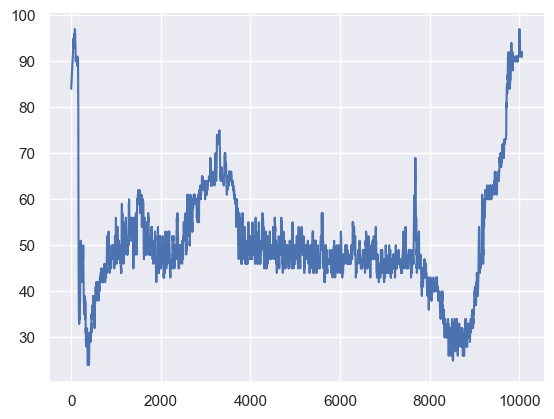

In [224]:
plt.plot(data_112['BIS'])

In [249]:
training_data = []

In [270]:
class model:
    
    my_model = None

    def __init__(self, model, data, scale):
        self.model = model
        self.data = data
        self.scale = scale
        
        
    def fit(self, features):
        X = self.data[features]
        y = self.data['BIS']
        
        if self.scale == True:
            scaled_X = StandardScaler()
            scaled_Y = StandardScaler()

            X = scaled_X.fit_transform(X)
            y = scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
        
        # Linear regression
        if self.model == 'lr':
            my_model = LinearRegression()
            my_model.fit(X, y)
                
            self.my_model = my_model
            print("Done training")
            
            
        # Decision tree
        if self.model == "tree":
            max_depth = 10
            my_model = DecisionTreeRegressor(max_depth=max_depth)
            my_model.fit(X, y)
            
            self.my_model = my_model
            print("Done training")
            
            
        # RandomForestRegressor
        if self.model == "forest":
            my_model = RandomForestRegressor(n_estimators=1000, criterion='squared_error',
                                            random_state=11, n_jobs=-1)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Support Vector Regression
        if self.model == 'svr':
            my_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Linear Support Vector regression
        if self.model == "lsvr":
            my_model = SVR(kernel='linear', C=1.0, epsilon=0.2)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Ridge regression 
        if self.model == 'rr':
            my_model = Ridge(alpha=1.0)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
        # Histogram-based Gradient boosting regression tree (Experimental)
        if self.model == 'hist_r':
            my_model = HistGradientBoostingRegressor(max_depth=10)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
        if self.model == "xgboost":
            my_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
            my_model.fit(X, y)
            self.my_model = my_model
            print('Done training')
            
            
            
            
            
            
            
            
            
            
    def predict(self, test_data, features, visualize=True, evaluate=True):
        
        if self.my_model == None:
            raise Exception("Call the fit() method to train a model")
            
        X = test_data[features]
        y = test_data['BIS']
        xmin, xmax = 0, 110
        
        if self.scale == True:
            test_scaled_X = StandardScaler()
            test_scaled_Y = StandardScaler()
            
            X = test_scaled_X.fit_transform(X)
            y = test_scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            # For the residual plot
            xmin, xmax = -3, 3
            
            
        # Predict
        y_pred = self.my_model.predict(X)
            
        # Visualize after predicting    
        if visualize == True:
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y, label="Actual BIS")
            plt.plot(y_pred, label="Predicted BIS")
            plt.xlabel('Samples')
            plt.ylabel('BIS')
            plt.legend(loc='upper left')
            plt.title("Depth of Anaesthesia assessment with EEG")
            plt.show()
            
            
        if evaluate == True:
            # Residual plot
            figure = plt.figure(figsize=(15, 10))
            plt.scatter(y_pred, y_pred - y, c='royalblue', marker='o',  edgecolor='white')
            plt.ylabel("Residuals")
            plt.xlabel("Predicted Values")
            plt.hlines(y=0, xmin=xmin, xmax=xmax, color='black', lw=2)
            plt.xlim([xmin, xmax])
            plt.show()
            
            
            # MSE and R^2
            mse = mean_squared_error(y, y_pred)
            
            print("MSE: %.3f" % mse)

                
                
        
            

In [271]:
# Testing a linear regression model
test_model = model('forest', data_78, scale=False)

test_model.fit(features)



Done training


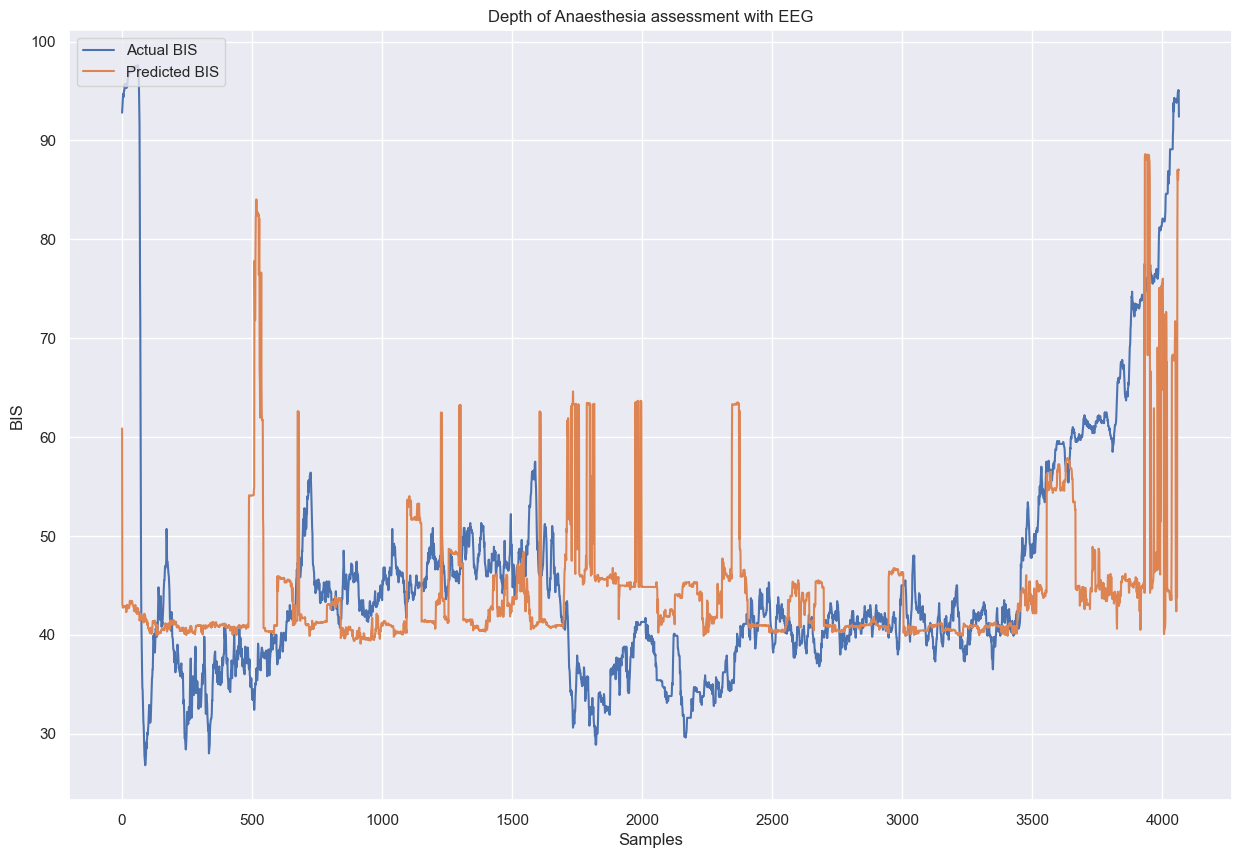

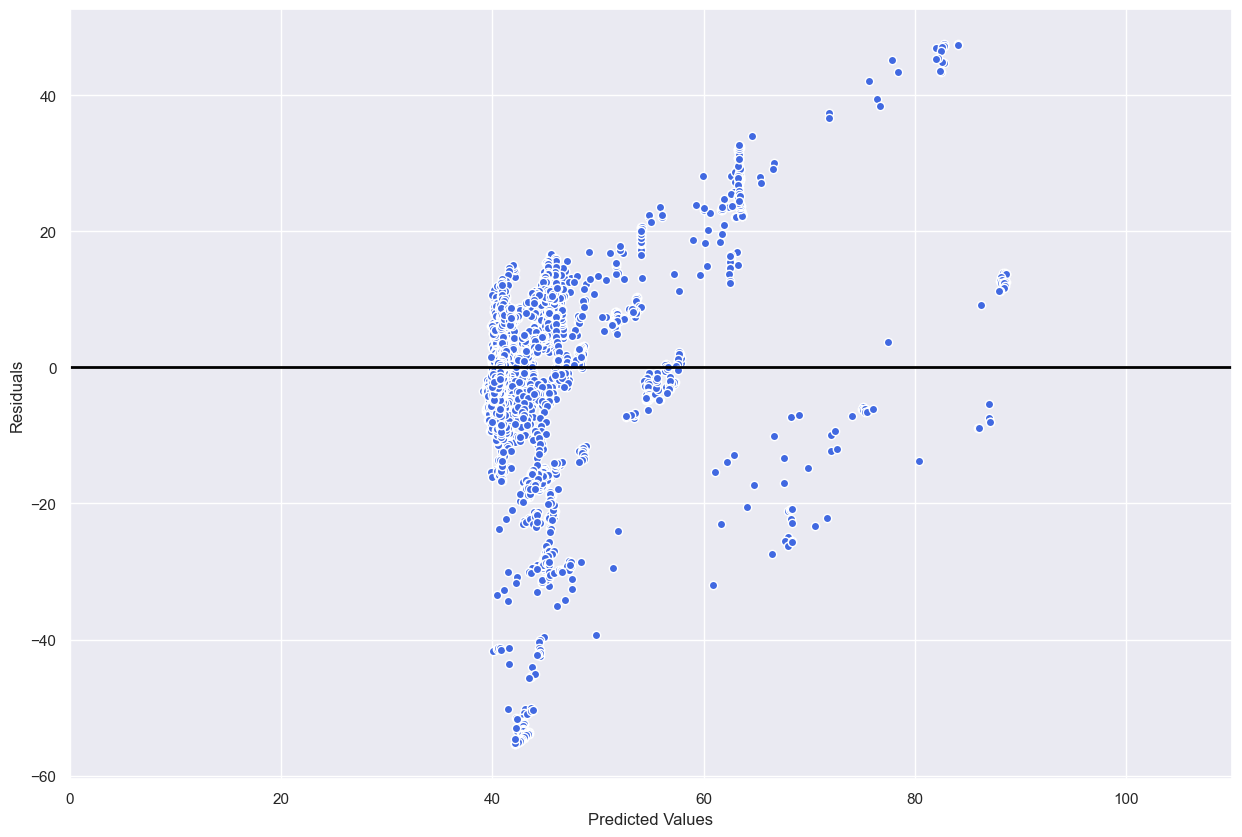

MSE: 164.550


In [272]:
test_model.predict(data_92, features)

In [269]:
features=['Perment_mode4', 'hm_mode2', 'disp_mode4', 'hc_mode2', 'lzc_mode2', 'Pet_mode3']

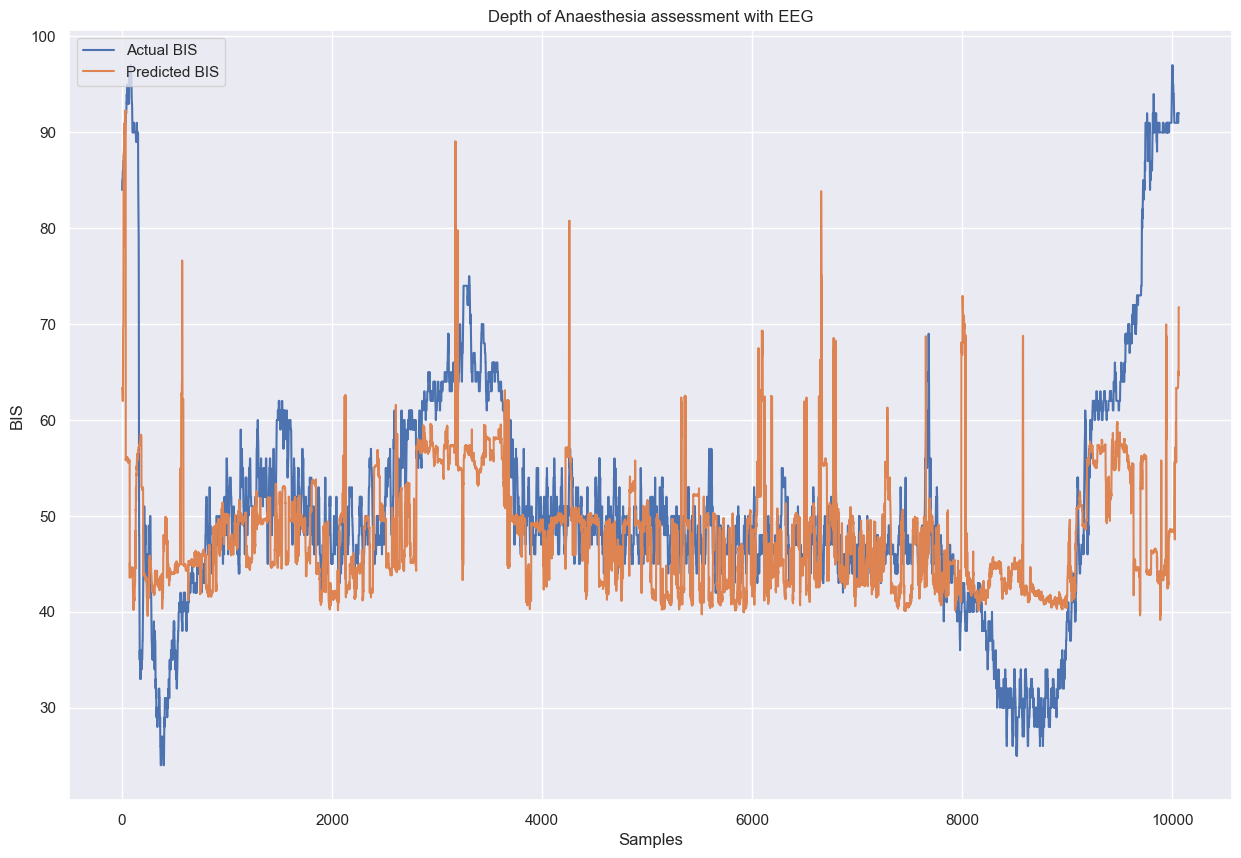

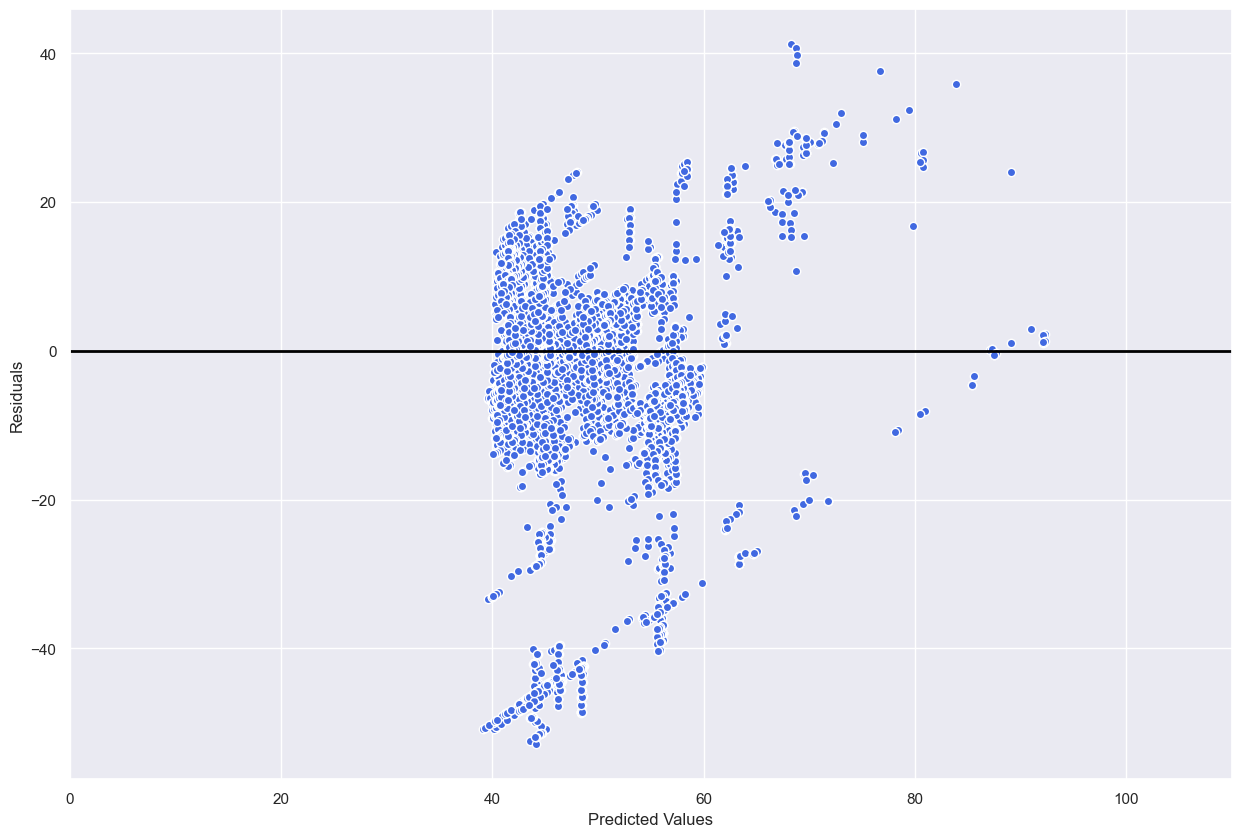

MSE: 143.638


In [273]:
test_model.predict(data_112, features)

In [274]:
data_78

Perment_mode4  Pet_mode3  disp_mode4  dispm_mode4  lzc_mode2  svd_mode2  \
0          2.579941   1.021758    1.650478     1.964798        662   1.137937   
1          2.580091   1.021764    1.655998     1.966469        666   1.139575   
2          2.580149   1.021780    1.653529     1.966705        664   1.140382   
3          2.580254   1.021796    1.657103     1.963155        660   1.140595   
4          2.580337   1.021796    1.660104     1.964489        662   1.140730   
...             ...        ...         ...          ...        ...        ...   
4060       2.580858   1.021916    1.708463     1.971139          2   1.174044   
4061       2.580827   1.021916    1.709664     1.967803          2   1.173289   
4062       2.580822   1.021899    1.709813     1.971203          2   1.173775   
4063       2.580863   1.021861    1.708174     1.969209          2   1.173565   
4064       2.580909   1.021850    1.702793     1.968979          2   1.175290   

      spec_mode2  hc_mode2  hm_mode2  hfd_mode4   BIS  
0       8.499814  1.156704  0.608682   2.026296  90.9  
1       8.522111  1.157650  0.610458   2.026370  89.3  
2       8.537083  1.156557  0.611846   2.025578  88.1  
3       8.537430  1.156233  0.612034   2.025724  87.0  
4       8.562505  1.155354  0.612545   2.025941  87.2  
...          ...       ...       ...        ...   ...  
4060    8.755532  1.137938  0.663846   2.025742  90.4  
4061    8.774293  1.138101  0.662613   2.026147  90.4  
4062    8.767233  1.140903  0.661795   2.027126  90.4  
4063    8.774087  1.141326  0.661457   2.026691  90.4  
4064    8.810083  1.141022  0.663472   2.026055  90.4  

[4065 rows x 11 columns]

In [275]:
X=data_78.drop('BIS', axis=1)
y=data_78['BIS']

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [280]:
knn=KNeighborsRegressor(n_neighbors=10, p=2, weights='distance')
knn.fit(X_train_scaled, y_train)
train_score=knn.score (X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

test_score=knn.score(X_test_scaled, y_test)
print('Train score:', train_score, 'Test score:', test_score)

Train score: 1.0 Test score: 0.9891272665592925


In [288]:
XX=data_92.drop('BIS', axis=1)
YY=data_92['BIS']

test_scaled_X = StandardScaler()
test_scaled_Y = StandardScaler()
            
X = test_scaled_X.fit_transform(XX)
y_true = test_scaled_Y.fit_transform(YY[:, np.newaxis]).flatten()
            
    
# For the residual plot
xmin, xmax = -3, 3

y_true = knn.predict(X)

ValueError: X has 7 features, but KNeighborsRegressor is expecting 10 features as input.

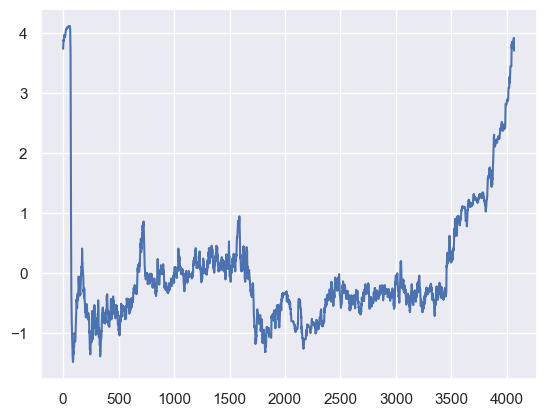

In [284]:
plt.plot(y_true)

In [285]:
XX=data_112.drop('BIS', axis=1)
YY=data_112['BIS']

test_scaled_X = StandardScaler()
test_scaled_Y = StandardScaler()
            
X = test_scaled_X.fit_transform(XX)
y_true = test_scaled_Y.fit_transform(YY[:, np.newaxis]).flatten()
            
    
# For the residual plot
xmin, xmax = -3, 3

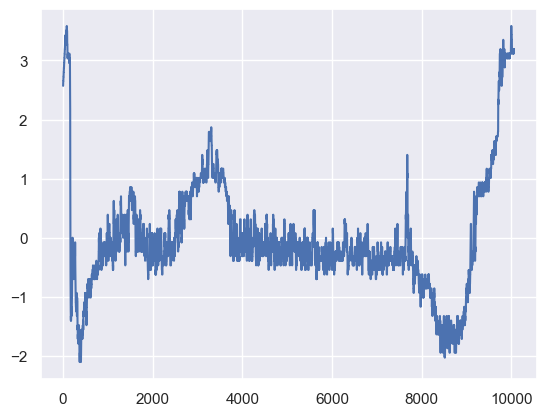

In [286]:
plt.plot(y_true)